# Predicting the NBA All-Stars with Machine Learning

The goal of this analysis is to predict the NBA All-Stars for a given year, based on NBA player data and All-Star selections in other years. This is accomplished by applying several machine learning classification algorithms on NBA player performance data. The analysis is based on the [Scikit-learn](http://scikit-learn.org) machine learning package, NBA player data are taken from [basketball-reference.com](https://www.basketball-reference.com).

## Import modules and libraries:

In [1]:
import NBAanalysissetup # See NBAanalysissetup.py

from NBAanalysissetup import MyModel, MyCM

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns

import copy
import operator
import sys
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.decomposition import PCA
from sklearn.mixture       import GaussianMixture
from sklearn.cluster       import KMeans, SpectralClustering

from sklearn.neighbors             import KNeighborsClassifier
from sklearn.linear_model          import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm                   import LinearSVC #, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process      import GaussianProcessClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble              import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble              import BaggingClassifier, VotingClassifier
from sklearn.neural_network        import MLPClassifier

from xgboost                       import XGBClassifier

from sklearn.model_selection import cross_validate, LeaveOneGroupOut, validation_curve

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, classification_report
#from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import fowlkes_mallows_score, silhouette_score, calinski_harabaz_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
start = time.time()

## User input

Choose the year you want to predict, between 2010 and 2018. The years that are not selected are used for cross-validation and training of the ML algorithms.

Choose the year you want to predict (*test_year*), between 2010 and 2018, and change the boolean variable *test_year_truth_is_known* according to whether the NBA All-Stars for *test_year* have been selected yet or not. The years that are not selected are used for cross-validation and training of the ML algorithms.

In [3]:
test_year = 2018 # Enter any year from 2010 until 2018

test_year_truth_is_known = True # Enter true/false if All-Stars have been selected yet for test_year or not

print("--> Test year = {}".format(test_year))

first_year = 2010 # First year for which data has been scraped
last_year  = 2018 # Last  year for which data has been scraped

train_years = list(range(first_year, last_year+1))

train_years.remove(test_year)

first_train_year = train_years[0]
last_train_year  = train_years[-1]
    
if (first_train_year < test_year < last_train_year):
    print("--> Train years = {}-{} except {}".format(first_train_year, last_train_year, test_year))
else:
    print("--> Train years = {}-{}".format(first_train_year, last_train_year))

--> Test year = 2018
--> Train years = 2010-2017


Choose whether you want to include advanced players statistics (e.g. *PER*, *VORP*, etc.) in the model or not,
and choose the minimum number of games a player has to have played per season to be included in the analysis:

In [4]:
includeadvancedstats = True # Enter True or False

if includeadvancedstats:
    print("--> Advanced statistics included")
else:
    print("--> Advanced statistics not included")
    
min_num_games = 41 # Enter any number between 0 and 82

print("--> Minimum number of games for each player =", min_num_games)

--> Advanced statistics included
--> Minimum number of games for each player = 41


## NBA player data

NBA player data from 2010-2018 from [basketball-reference.com](https://www.basketball-reference.com) have been saved as csv-files in the **data** directory using the scraper functions in [NBAanalysissetup.py](NBAanalysissetup.py).

In [5]:
df_train, df_test = NBAanalysissetup.loaddata_allyears(train_years, test_year, includeadvancedstats, target='allstar')

--> Loading train year 2009-2010 ...
--> Loading train year 2010-2011 ...
--> Loading train year 2011-2012 ...
--> Loading train year 2012-2013 ...
--> Loading train year 2013-2014 ...
--> Loading train year 2014-2015 ...
--> Loading train year 2015-2016 ...
--> Loading train year 2016-2017 ...
--> Loading test  year 2017-2018 ...


Print table of All-Stars in *test_year*:

In [6]:
print_year = test_year

print("--> All-Stars {} :".format(print_year))
if (print_year == test_year):
    df_tmp = df_test[df_test['AS'] > 0.5]
else:
    df_tmp = df_train[(df_train['YEAR'] == print_year) & (df_train['AS'] > 0.5)]
#display(df_tmp)
cm = sns.light_palette("green", as_cmap=True)
df_tmp_style = df_tmp.style.background_gradient(cmap=cm, axis=0)
display(df_tmp_style)

--> All-Stars 2018 :


Print table of non-All-Stars in a specific year:

Select only players which have played at least *min_num_games* number of games in a season:

In [7]:
print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])
print("")

df_train = df_train[df_train['GS'] >= min_num_games]
df_test  = df_test [df_test ['GS'] >= min_num_games]

print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])

# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players in train set = 3775
--> # of players in test  set = 540

--> # of players in train set = 1104
--> # of players in test  set = 141


NaN handling:

In [8]:
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Replace NaNs with 0s in the following columns:

df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)

if (includeadvancedstats):
    df_train[['TS%', '3PAr', 'FTr']] = df_train[['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_test [['TS%', '3PAr', 'FTr']] = df_test [['TS%', '3PAr', 'FTr']].fillna(value=0)
    
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Remove remaining players with NaNs, if necessary:

if (df_train.shape[0] - df_train.dropna().shape[0] != 0):
    #print("--> Players in train set with NaNs:")
    #print(df_train[df_train.isnull().any(axis=1)])
    #print("")
    df_train.dropna(inplace=True)
    print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])

if (df_test.shape[0] - df_test.dropna().shape[0] != 0):
    #print("--> Players in test set with NaNs:")
    #print(df_test[df_test.isnull().any(axis=1)])
    #print("")
    df_test.dropna(inplace=True)
    print("--> # of players with NaNs in test  set =", df_test.shape[0] - df_test.dropna().shape[0])
    
# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players with NaNs in train set = 56
--> # of players with NaNs in test  set = 4

--> # of players with NaNs in train set = 0
--> # of players with NaNs in test  set = 0



Check number of All-Stars in dataframes:

In [9]:
# Check All-Star data in data files:

all_years = train_years[:]
all_years.append(test_year)

n_AS_dict = {} 

for year in all_years:
    shellcommand = "wc -l data/NBA_allstars_{}-{}.csv | awk '{{print $1}}'".format(year-1, year)
    n = !{shellcommand}
    n_AS_dict[year] = int(n[0]) - 1 # Don't count header
    
# Check All-Star data in dataframes:

for year in train_years:
    n_AS_df  = df_train[(df_train['YEAR'] == year) & (df_train['AS'] > 0.5)].shape[0]
    n_AS_tot = n_AS_dict[year]
    n_tot    = df_train[(df_train['YEAR'] == year)].shape[0]
    print("--> Train year {}: {} out of {} All-Stars in analysis (Total # of players = {})".format(year, n_AS_df, n_AS_tot, n_tot))
    
n_AS_df  = df_test[df_test['AS'] > 0.5].shape[0]
n_AS_tot = n_AS_dict[test_year]
n_tot    = df_test.shape[0]
print("--> Test  year {}: {} out of {} All-Stars in analysis (Total # of players = {})".format(test_year, n_AS_df, n_AS_tot, n_tot))

--> Train year 2010: 27 out of 28 All-Stars in analysis (Total # of players = 142)
--> Train year 2011: 24 out of 25 All-Stars in analysis (Total # of players = 143)
--> Train year 2012: 24 out of 25 All-Stars in analysis (Total # of players = 118)
--> Train year 2013: 24 out of 25 All-Stars in analysis (Total # of players = 143)
--> Train year 2014: 24 out of 25 All-Stars in analysis (Total # of players = 143)
--> Train year 2015: 25 out of 28 All-Stars in analysis (Total # of players = 133)
--> Train year 2016: 26 out of 26 All-Stars in analysis (Total # of players = 143)
--> Train year 2017: 25 out of 25 All-Stars in analysis (Total # of players = 139)
--> Test  year 2018: 28 out of 28 All-Stars in analysis (Total # of players = 141)


Prepare data and create features (*X*) and target (*y*) dataframes needed for Scikit-learn methods:

In [10]:
# Features dataframes (AS and YEAR are dropped: AS is the target variable, YEAR is only used for cross-validation):

X_train = df_train.drop(['AS', 'YEAR'], axis=1)
X_test  = df_test .drop(['AS', 'YEAR'], axis=1)

X_list = [X_train, X_test]

for X in X_list:
    
    # Remove features:
    
    X.drop(['Player', 'Pos', 'Tm', 'Age', 'TC',                             # No predictive power
            'FG', 'FGA', 'FG%', '3P%', '2P%', 'FT%', 'eFG%', 'TRB', 'PTS'], # Correlated with other features
           axis=1, inplace=True)

    if includeadvancedstats:
        X.drop(['TS%', '3PAr', 'FTr', 'TRB%', 'WS', 'WS/48', 'BPM',         # Correlated with other features 
                'ORB', 'DRB', 'AST', 'TOV', 'STL', 'BLK'],                  # Correlated with other features
               axis=1, inplace=True) 

    '''
    X.drop(['Player', 'Pos', 'Tm', 'Age', 'TC', 
            'FG', 'FGA', 'FG%', '2P', '2PA', '2P%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 
            'TRB', 'ORB', 'DRB', 'AST', 'TOV', 'STL', 'BLK', 'PF'], # Correlated with other features
           axis=1, inplace=True)

    if includeadvancedstats:
        X.drop(['3PAr', 'FTr', 'TRB%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 
                'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM'], 
               axis=1, inplace=True) 
    '''
    
    # Replace GS by GS/G, and MP by MP/G:

    #X['GS'] = X['GS'].div(X['G'].values, axis=0).round(2)
    #X['MP'] = X['MP'].div(X['G'].values, axis=0).round(1)
    #X['TW'] = X['TW'].div(82, axis=0)           .round(2)
    #X.rename(columns={'GS': 'GS/G', 'MP': 'MP/G', 'TW': 'TW/82'}, inplace=True)
    
    '''
    # Scale total-type features by MP/48:

    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']] = \
    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']].div(X['MP/48'].values, axis=0)
    X.rename(columns={'3P': '3P/48', '3PA': '3PA/48', 'FT': 'FT/48', 'FTA': 'FTA/48', 
                      '2P': '2P/48', '2PA': '2PA/48', 'PF': 'PF/48'}, inplace=True)
    
    if includeadvancedstats:
        X[['OWS', 'DWS']] = \
        X[['OWS', 'DWS']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'OWS': 'OWS/48', 'DWS': 'DWS/48'}, inplace=True)
    else:
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']] = \
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'ORB': 'ORB/48', 'DRB': 'DRB/48', 'AST': 'AST/48', 'PF': 'PF/48',
                          'BLK': 'BLK/48', 'TOV': 'TOV/48', 'STL': 'STL/48'}, inplace=True)
    '''
    
# Target dataframes (target = AS, a binary variable introduced to indicate All-Star status):

y_train = df_train['AS']
y_test  = df_test ['AS']

n_players_train = X_train.shape[0]
n_players_test  = X_test .shape[0]
n_features = X_train.shape[1] # equals X_test.shape[1]

print("--> Train data set : # of players = {:4}, # of features = {}".format(n_players_train, n_features))
print("--> Test  data set : # of players = {:4}, # of features = {}".format(n_players_test,  n_features))
print("")

print("--> Model features : ", list(X_train.columns))

--> Train data set : # of players = 1104, # of features = 24
--> Test  data set : # of players =  141, # of features = 24

--> Model features :  ['G', 'GS', 'MP', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF', 'PER', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'OBPM', 'DBPM', 'VORP', 'TW']


Scale feature dataframes to accommodate ML algorithms:

In [11]:
feature_names = X_train.columns # This is no longer available after transformation with scaler

#X_scaler = StandardScaler(with_mean=True, with_std=True) # Scaler with zero mean and unit variance
#X_scaler = MinMaxScaler() # Scales features to range 0 to 1 (or -1 to 1 if there are negative values)
X_scaler = RobustScaler() # Similar method to the MinMaxScaler but more robust to outliers

X_train = X_scaler.fit_transform(X_train) # Fit scaler to training data and transform X_train
X_test  = X_scaler.transform(X_test)      # Transform X_test using fitted scaler

## Unsupervised Learning: PCA & Clustering

Explore the possible correlation between features and how they differ between All-Stars and non-All-Stars by plotting their distributions in training data:

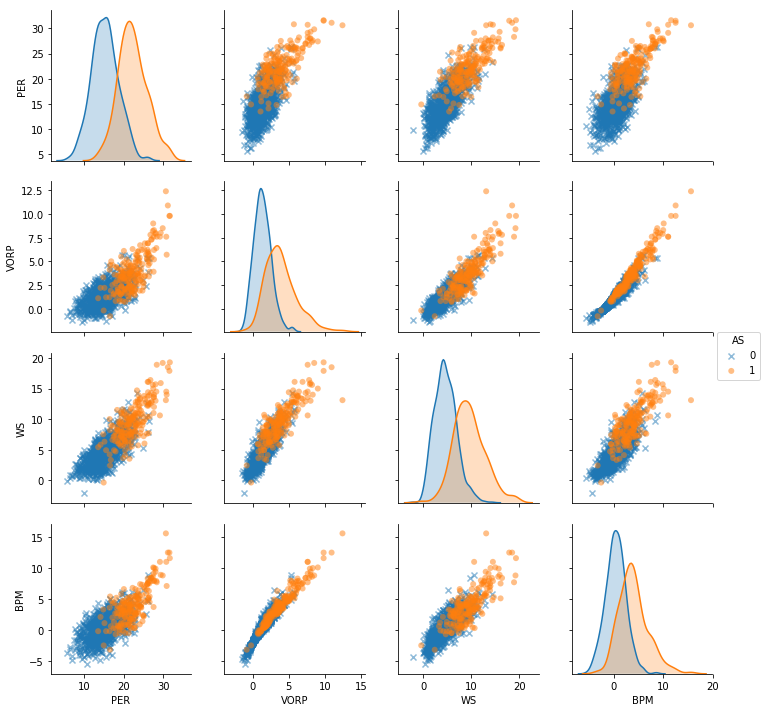

In [12]:
if includeadvancedstats:
    plotvariables = ['PER', 'VORP', 'WS', 'BPM']
else:
    plotvariables = ['PTS', 'eFG%', 'MP']

_ = sns.pairplot(df_train, vars=plotvariables, hue="AS", diag_kind="kde", diag_kws=dict(shade=True),
                 markers = ['x','o'], plot_kws=dict(edgecolor="none", alpha=0.5))

Use Principal Component Analysis for dimensionality reduction and plot the results:

--> The amount of variance explained by each of the eigen vectors of the covariance matrix of X_train:


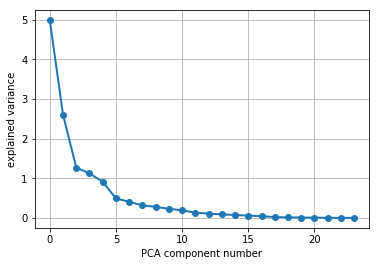

--> Training data in the PCA0-PCA1-PCA2-PCA3 space, where PCA components are ordered by the
    amount of variance they have in the data with respect to the target variable:


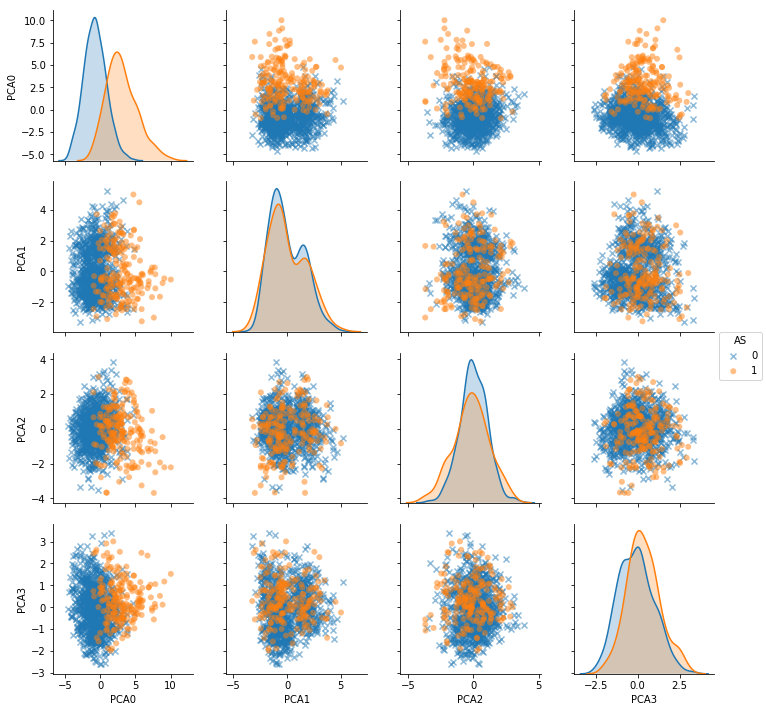

In [13]:
PCA_model = PCA(svd_solver='full') # Instantiate PCA model with hyperparameters

PCA_model.fit(X_train)                                   # Fit model to data (unsupervised: y is not specified)

print("--> The amount of variance explained by each of the eigen vectors of the covariance matrix of X_train:")

plt.plot(PCA_model.explained_variance_, linewidth=2, marker='o')
#plt.axis('tight')
plt.xlabel('PCA component number')
plt.ylabel('explained variance')
plt.grid(True)
plt.show()

X_2D = PCA_model.transform(X_train) # Transform the data to the PCA basis (which are linearly uncorrelated variables)

df_train['PCA0'] = X_2D[:, 0] # PCA0 is the principal component that has     maximum variance in the data
df_train['PCA1'] = X_2D[:, 1] # PCA1 is the principal component that has 2nd-maximum variance in the data
df_train['PCA2'] = X_2D[:, 2] # etc.
df_train['PCA3'] = X_2D[:, 3]

print("--> Training data in the PCA0-PCA1-PCA2-PCA3 space, where PCA components are ordered by the")
print("    amount of variance they have in the data with respect to the target variable:")

plotvariables = ['PCA0', 'PCA1', 'PCA2', 'PCA3']
_ = sns.pairplot(df_train, vars=plotvariables, hue="AS", diag_kind="kde", diag_kws=dict(shade=True),
                 markers = ['x','o'], plot_kws=dict(edgecolor="none", alpha=0.5))

Apply clustering algorithms to identify clusters in the training data, plot clusters and calculate custering performance scores:

--> KMeans clusters:


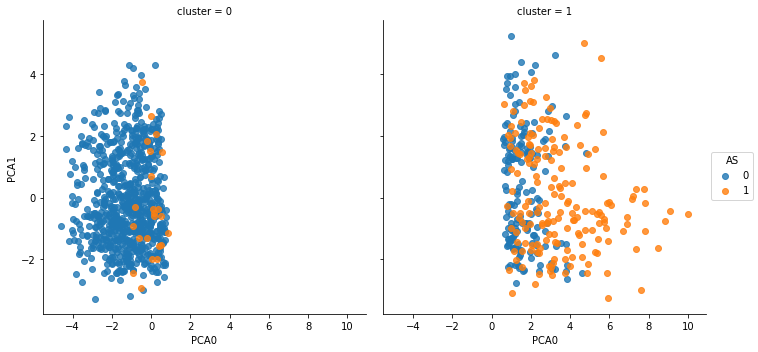

--> Gaussian Mixture clusters:


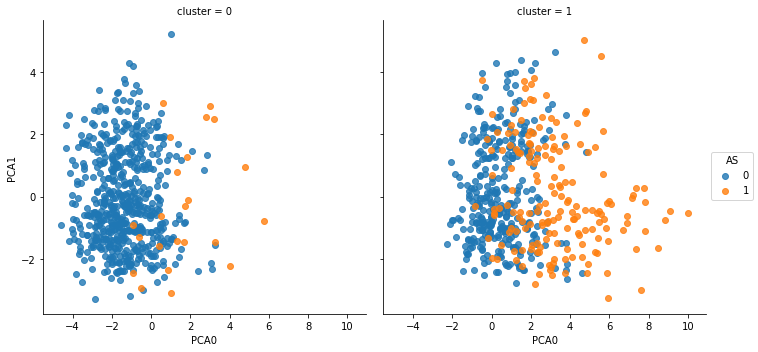

--> Spectral Clustering clusters:


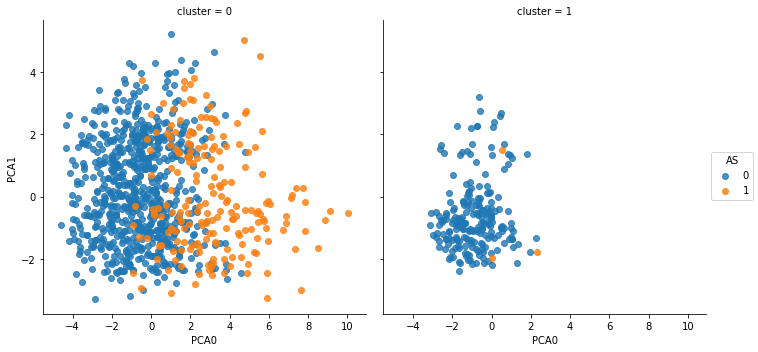


--> Clustering performance scores for all models:


KMeans  Gaussian Mixture  \
Adjusted Rand Score             0.385685          0.111767   
Adjusted Mutual Info Score      0.257517          0.119274   
Normalized Mutual Info Score    0.296431          0.145088   
Homogeneity Score               0.340507          0.175636   
Completeness Score              0.258059          0.119853   
V-Measure Score                 0.293605          0.142479   
Fowlkes-Mallows Score           0.776611          0.641150   
Silhouette Score                0.229245          0.115713   
Calinski-Harabaz Score        331.441616        181.087173   

                              Spectral Clustering (Random) (Perfect)  
Adjusted Rand Score                     -0.100035        0         1  
Adjusted Mutual Info Score               0.065191        0         1  
Normalized Mutual Info Score             0.067439        0         1  
Homogeneity Score                        0.068851        0         1  
Completeness Score                       0.066056        0         1  
V-Measure Score                          0.067425        0         1  
Fowlkes-Mallows Score                    0.665190        0         1  
Silhouette Score                        -0.050533     N.A.      N.A.  
Calinski-Harabaz Score                  32.655310     N.A.      N.A.

In [14]:
cluster_models = []

estimator_name = 'KMeans'
estimator = KMeans(n_clusters=2, init='random')                      # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

estimator_name = 'Gaussian Mixture'
estimator = GaussianMixture(n_components=2, covariance_type='full')  # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

estimator_name = 'Spectral Clustering'
estimator = SpectralClustering(n_clusters=2)                         # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

cluster_score_names = ['Adjusted Rand Score', 'Adjusted Mutual Info Score', 'Normalized Mutual Info Score',
                       'Homogeneity Score', 'Completeness Score', 'V-Measure Score',
                       'Fowlkes-Mallows Score', 'Silhouette Score', 'Calinski-Harabaz Score']

df_clusterscores = pd.DataFrame()

for model in cluster_models:
                      
    model[1].fit(X_train)                                # Fit model to data (unsupervised: y is not specified)
    
    if hasattr(model[1], 'labels_'):                     # Determine cluster labels
        y_prediction = model[1].labels_.astype(np.int)
    else:
        y_prediction = model[1].predict(X_train)

    df_train['cluster'] = y_prediction

    print("-->", model[0], "clusters:")
    sns.lmplot("PCA0", "PCA1", data=df_train, hue='AS', col='cluster', fit_reg=False)
    plt.show()

    # Calculate clustering performance scores based on the truth
    
    adjusted_rand_s          = adjusted_rand_score               (y_train, y_prediction)
    adjusted_mutual_info_s   = adjusted_mutual_info_score        (y_train, y_prediction)
    normalized_mutual_info_s = normalized_mutual_info_score      (y_train, y_prediction)
    fowlkes_mallows_s        = fowlkes_mallows_score             (y_train, y_prediction)
    hcv                      = homogeneity_completeness_v_measure(y_train, y_prediction)    
    homogeneity              = hcv[0]
    completeness             = hcv[1]
    v_measure                = hcv[2]

    # Calculate clustering performance scores based on the clusters themselves (i.e. not the truth)
    
    silhouette_s       = silhouette_score      (X_train, y_prediction, metric='euclidean')
    calinski_harabaz_s = calinski_harabaz_score(X_train, y_prediction)
        
    df_clusterscores.loc[cluster_score_names[0], model[0]] = adjusted_rand_s
    df_clusterscores.loc[cluster_score_names[1], model[0]] = adjusted_mutual_info_s
    df_clusterscores.loc[cluster_score_names[2], model[0]] = normalized_mutual_info_s
    df_clusterscores.loc[cluster_score_names[3], model[0]] = homogeneity
    df_clusterscores.loc[cluster_score_names[4], model[0]] = completeness
    df_clusterscores.loc[cluster_score_names[5], model[0]] = v_measure
    df_clusterscores.loc[cluster_score_names[6], model[0]] = fowlkes_mallows_s
    df_clusterscores.loc[cluster_score_names[7], model[0]] = silhouette_s
    df_clusterscores.loc[cluster_score_names[8], model[0]] = calinski_harabaz_s

df_clusterscores['(Random)' ] = 0
df_clusterscores['(Perfect)'] = 1

df_clusterscores.loc['Silhouette Score',       '(Random)' ] = 'N.A.'
df_clusterscores.loc['Silhouette Score',       '(Perfect)'] = 'N.A.'
df_clusterscores.loc['Calinski-Harabaz Score', '(Random)' ] = 'N.A.'
df_clusterscores.loc['Calinski-Harabaz Score', '(Perfect)'] = 'N.A.'
    
print("")
print("--> Clustering performance scores for all models:")
display(df_clusterscores)

#### Conclusion: 

The unsupervised learning algorithms tested in this analysis are unable to identify the NBA All-Stars and non-All-Stars as two clearly separated clusters.

## Supervised Learning: Classification

Select ML classifiers, set hyper-parameters and instantiate models:

In [15]:
rseed = 666 # Set random_state of model (where applicable) to specific seed, to tune hyper-parameters

models = []

estimator_name = 'Nearest Neighbours Classifier'
n_n = 5
w   = 'uniform' # 'distance'
estimator = KNeighborsClassifier(n_neighbors=n_n, weights=w)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Logistic Regression Classifier'
C = 10  # A smaller value for C results in more regularization (variance reduction due to noise in data)
p = 'l2' # penalty="l1" enables Lasso regularization (i.e. sparsity)  => Feature selection 
#          penalty="l2" enables Ridge regularization (i.e. shrinkage) => Coefficient suppression
estimator = LogisticRegression(C=C, penalty=p)
models.append(MyModel(estimator_name, estimator))

#estimator_name = 'Support Vector Machine Classifier'
estimator_name = 'Linear Support Vector Machine Classifier'
#k = 'rbf' # 'linear' # 'poly', 'rbf'
#d = 3 # for kernel='poly'
C = 1
p = 'l2'
#estimator = SVC(kernel=k, degree=d, probability=True, C=C, random_state=rseed)
estimator = LinearSVC(C=C, penalty=p, dual=False)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Stochastic Gradient Descent Classifier'
l = 'hinge' # 'log', 'modified_huber', 'squared_hinge', 'perceptron'
p = 'l2'
estimator = SGDClassifier(loss=l, penalty=p, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

#estimator_name = 'Quadratic Discriminant Analysis Classifier'
estimator_name = 'Linear Discriminant Analysis Classifier'
#estimator = QuadraticDiscriminantAnalysis()
so = 'svd' # 'lsqr', 'eigen' (if 'svd', shrinkage should be None)
sh = None # 'auto' 
estimator = LinearDiscriminantAnalysis(solver=so, shrinkage=sh)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Passive Aggressive Classifier'
C = 0.001
l = 'squared_hinge' # 'hinge'
estimator = PassiveAggressiveClassifier(C=C, loss=l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

'''
estimator_name = 'Perceptron Classifier'
p   = 'l2' # 'l1', 'elasticnet'
a   = 0.0001 # regularization factor
m_i = 5 # maximum number of passes over the training data (aka epochs) 
estimator = Perceptron(penalty=p, alpha=a, max_iter=m_i, random_state=rseed)
models.append(MyModel(estimator_name, estimator))
'''

estimator_name = 'Neural Network Classifier'
a = 0.0001 # regularization factor
estimator = MLPClassifier(alpha=a, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gaussian Process Classifier' # (CV is slowwwwwwww)
estimator = GaussianProcessClassifier(random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gaussian Naive Bayes Classifier'
estimator = GaussianNB()
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Decision Tree Classifier'
m_d = None   # i.e. nodes are expanded until leafs are pure 
m_f = 'auto' # The number of features to consider when looking for the best split. 
#              'auto' => max_features=sqrt(n_features) 
estimator = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Random Forest Classifier'
m_d = None
m_f = 'auto'
n_e = 100
estimator = RandomForestClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extra Randomized Forest Classifier'
n_e = 100
m_d = None
m_f = 'auto'
estimator = ExtraTreesClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gradient Boosted Decision Tree Classifier'
n_e = 100
m_d = 3
l_l = 0.1
estimator = GradientBoostingClassifier(n_estimators=n_e, max_depth=m_d, learning_rate=l_l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Adaptive Boosted Decision Tree Classifier'
n_e = 100
l_l = 0.1
estimator = AdaBoostClassifier(n_estimators=n_e, learning_rate=l_l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extreme Gradient Boosted Decision Tree Regressor'
n_e = 200
m_d = 3
l_r = 0.1
estimator = XGBClassifier(n_estimators=n_e, max_depth=m_d, learning_rate=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Bagged Decision Tree Classifier'
m_d = None
m_f = 'auto'
dtc = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, random_state=rseed)
estimator = BaggingClassifier(base_estimator=dtc, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

print("--> ML classifiers implemented in this analysis:")
print("")

model_names = []

for counter, model in enumerate(models, 0):
    print("{:2} : {}".format(counter, model.estimator_name))
    #print("     Model parameters : ", mymodel.estimator.get_params())
    model_names.append(model.estimator_name)

--> ML classifiers implemented in this analysis:

 0 : Nearest Neighbours Classifier
 1 : Logistic Regression Classifier
 2 : Linear Support Vector Machine Classifier
 3 : Stochastic Gradient Descent Classifier
 4 : Linear Discriminant Analysis Classifier
 5 : Passive Aggressive Classifier
 6 : Neural Network Classifier
 7 : Gaussian Process Classifier
 8 : Gaussian Naive Bayes Classifier
 9 : Decision Tree Classifier
10 : Random Forest Classifier
11 : Extra Randomized Forest Classifier
12 : Gradient Boosted Decision Tree Classifier
13 : Adaptive Boosted Decision Tree Classifier
14 : Extreme Gradient Boosted Decision Tree Regressor
15 : Bagged Decision Tree Classifier


## Cross-validation

Cross-validate the model using training data and the *LeaveOneGroupOut* cross-validation scheme in which a group is defined as a single NBA season:

In [16]:
logo = LeaveOneGroupOut()

cv_groups = df_train['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

Plot validation curves:

--> Plotting validation curves for Logistic Regression Classifier :


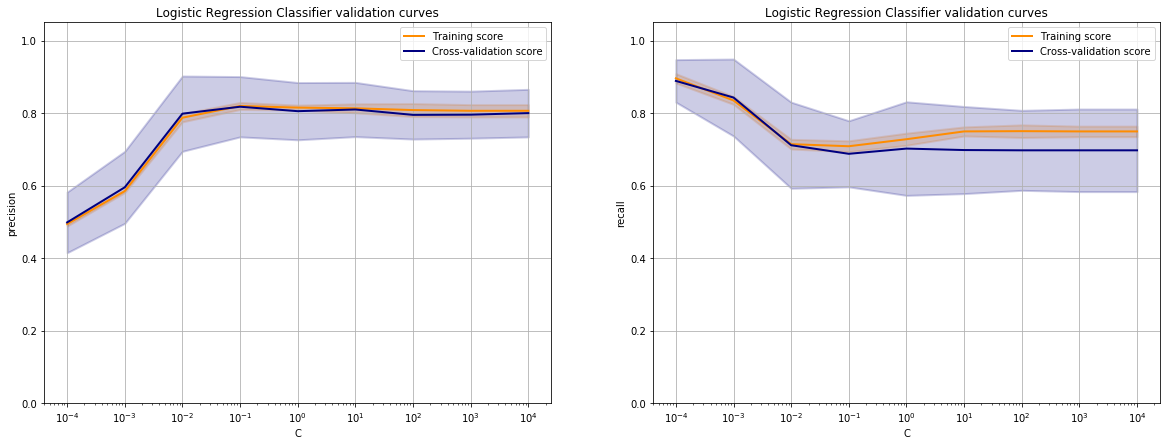

In [17]:
model = models[1] # LogisticRegression

classifier = model.estimator

print("--> Plotting validation curves for", model.estimator_name, ":")

min_logspace = -4
max_logspace =  4
param_range = np.logspace(min_logspace, max_logspace, (abs(min_logspace)+abs(max_logspace)+1))
#param_range = [2,4,6,8,10] #[3, 7, 11, 15]
#param_name = 'n_neighbors'
#param_name = 'alpha'
param_name = 'C'
#param_name = 'max_depth'

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)

scoring_metric = 'precision'

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

train_scores, test_scores = validation_curve(classifier, X_train, y_train, param_name=param_name, 
                                             param_range=param_range, cv=cv_logo, scoring=scoring_metric)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std (train_scores, axis=1)
test_scores_mean  = np.mean(test_scores,  axis=1)
test_scores_std   = np.std (test_scores,  axis=1)

plt.title("{} validation curves".format(model.estimator_name))
plt.xlabel(param_name)
plt.ylabel(scoring_metric)
plt.ylim(0.0, 1.05)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
#plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.2, color="darkorange", lw=2)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
#plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.2, color="navy", lw=2)
plt.grid(True)
plt.legend(loc="best");

plt.subplot(1, 2, 2)

scoring_metric = 'recall'

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

train_scores, test_scores = validation_curve(classifier, X_train, y_train, param_name=param_name, 
                                             param_range=param_range, cv=cv_logo, scoring=scoring_metric)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std (train_scores, axis=1)
test_scores_mean  = np.mean(test_scores,  axis=1)
test_scores_std   = np.std (test_scores,  axis=1)

plt.title("{} validation curves".format(model.estimator_name))
plt.xlabel(param_name)
plt.ylabel(scoring_metric)
plt.ylim(0.0, 1.05)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
#plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.2, color="darkorange", lw=2)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
#plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.2, color="navy", lw=2)
plt.grid(True)
plt.legend(loc="best");

Calculate classification scores:

In [18]:
X_train = np.array(X_train) # To accommodate X_train = X_training[train_index] and X_test = X_training[test_index]
y_train = np.array(y_train) # To accommodate y_train = y_training[train_index] and y_test = y_training[test_index]

cv_scores = []

for model in models:
    
    model.reset()
    
    classifier      = model.estimator
    classifier_name = model.estimator_name
    
    model.YEAR_cvgroups = train_years
    
    PRE_cvgroups = []
    REC_cvgroups = []
    F1_cvgroups  = []
    ACC_cvgroups = []
    FPR_cvgroups = []
    
    cvimportances  = []
    cvcoefficients = []

    FPR_ROC_cvgroups = []
    TPR_ROC_cvgroups = []
    AUC_ROC_cvgroups = []
    PRE_PR_cvgroups  = []
    REC_PR_cvgroups  = []
    AUC_PR_cvgroups  = []
    
    print("--> Cross-validating", classifier_name, "...")
    
    for train_index, test_index in logo.split(X_train, y_train, groups=cv_groups):

        X_cvtrain = X_train[train_index]
        X_cvtest  = X_train[test_index]
        y_cvtrain = y_train[train_index]
        y_cvtest  = y_train[test_index]
                       
        classifier.fit(X_cvtrain, y_cvtrain)
    
        y_cvprediction = classifier.predict(X_cvtest) 
        y_cvtruth      = y_cvtest.tolist()
        
        CM = MyCM(confusion_matrix(y_cvtruth, y_cvprediction))
        
        PRE_cvgroups.append(CM.precision)
        REC_cvgroups.append(CM.recall)
        F1_cvgroups .append(CM.f1)
        ACC_cvgroups.append(CM.accuracy)
        FPR_cvgroups.append(CM.fpr)
        
        if hasattr(classifier, "feature_importances_"):
            cvimportances.append(classifier.feature_importances_)
            
        if hasattr(classifier, "coef_"):
            cvcoefficients.append(classifier.coef_.ravel())
            
        '''
        if hasattr(classifier, 'predict_proba'):
            y_cvscore = classifier.predict_proba(X_cvtest)
            fpr, tpr, thresholds_roc = roc_curve             (y_cvtest, y_cvscore[:, 1])
            pre, rec, thresholds_pr  = precision_recall_curve(y_cvtest, y_cvscore[:, 1])
        else:
            y_cvscore = classifier.decision_function(X_cvtest)
            fpr, tpr, thresholds_roc = roc_curve             (y_cvtest, y_cvscore)
            pre, rec, thresholds_pr  = precision_recall_curve(y_cvtest, y_cvscore)
        '''
        
        if hasattr(classifier, 'decision_function'):
            y_cvscore = classifier.decision_function(X_cvtest)
            fpr, tpr, thresholds_roc = roc_curve             (y_cvtest, y_cvscore)
            pre, rec, thresholds_pr  = precision_recall_curve(y_cvtest, y_cvscore)
        else:
            y_cvscore = classifier.predict_proba(X_cvtest)
            fpr, tpr, thresholds_roc = roc_curve             (y_cvtest, y_cvscore[:, 1])
            pre, rec, thresholds_pr  = precision_recall_curve(y_cvtest, y_cvscore[:, 1])

        roc_auc = auc(fpr, tpr)
        pr_auc  = auc(rec, pre)
        rec = rec[::-1] # reverse list
        pre = pre[::-1] # reverse list
        
        FPR_ROC_cvgroups.append(fpr)
        TPR_ROC_cvgroups.append(tpr)
        AUC_ROC_cvgroups.append(roc_auc)
        PRE_PR_cvgroups.append(pre)
        REC_PR_cvgroups.append(rec)
        AUC_PR_cvgroups.append(pr_auc)
        
    model.PRE_cvgroups = PRE_cvgroups
    model.REC_cvgroups = REC_cvgroups
    model.F1_cvgroups  = F1_cvgroups
    model.ACC_cvgroups = ACC_cvgroups
    model.FPR_cvgroups = FPR_cvgroups
    
    model.cvimportances  = cvimportances
    model.cvcoefficients = cvcoefficients

    model.FPR_ROC_cvgroups = FPR_ROC_cvgroups
    model.TPR_ROC_cvgroups = TPR_ROC_cvgroups
    model.AUC_ROC_cvgroups = AUC_ROC_cvgroups
    model.PRE_PR_cvgroups  = PRE_PR_cvgroups
    model.REC_PR_cvgroups  = REC_PR_cvgroups
    model.AUC_PR_cvgroups  = AUC_PR_cvgroups
    
    cv_scores.append({'Estimator'      : classifier_name, 
                      'Precision mean' : (np.mean(model.PRE_cvgroups)*100).round(1),
                      'Precision std'  : (np.std (model.PRE_cvgroups)*100).round(1),
                      'Recall mean'    : (np.mean(model.REC_cvgroups)*100).round(1),
                      'Recall std'     : (np.std (model.REC_cvgroups)*100).round(1),
                      'F1 mean'        : (np.mean(model.F1_cvgroups )*100).round(1),
                      'F1 std'         : (np.std (model.F1_cvgroups )*100).round(1),
                      'Accuracy mean'  : (np.mean(model.ACC_cvgroups)*100).round(1),
                      'Accuracy std'   : (np.std (model.ACC_cvgroups)*100).round(1),
                      'FPR mean'       : (np.mean(model.FPR_cvgroups)*100).round(1),
                      'FPR std'        : (np.std (model.FPR_cvgroups)*100).round(1)})
    
print("")
print("--> Classification scores for all models (mean and std over all years):")

columnorder = ['Estimator', 'Precision mean', 'Precision std', 'Recall mean', 'Recall std', 
               'F1 mean', 'F1 std', 'Accuracy mean', 'Accuracy std', 'FPR mean', 'FPR std']

df_cv_scores = pd.DataFrame(cv_scores, columns=columnorder)
cm = sns.light_palette("green", as_cmap=True)
subset_scores = ['Precision mean', 'Recall mean', 'F1 mean']
df_cv_scores_style = df_cv_scores.style.background_gradient(subset=subset_scores, cmap=cm, axis=0)
display(df_cv_scores_style)

--> Cross-validating Nearest Neighbours Classifier ...
--> Cross-validating Logistic Regression Classifier ...
--> Cross-validating Linear Support Vector Machine Classifier ...
--> Cross-validating Stochastic Gradient Descent Classifier ...
--> Cross-validating Linear Discriminant Analysis Classifier ...
--> Cross-validating Passive Aggressive Classifier ...
--> Cross-validating Neural Network Classifier ...
--> Cross-validating Gaussian Process Classifier ...
--> Cross-validating Gaussian Naive Bayes Classifier ...
--> Cross-validating Decision Tree Classifier ...
--> Cross-validating Random Forest Classifier ...
--> Cross-validating Extra Randomized Forest Classifier ...
--> Cross-validating Gradient Boosted Decision Tree Classifier ...
--> Cross-validating Adaptive Boosted Decision Tree Classifier ...
--> Cross-validating Extreme Gradient Boosted Decision Tree Regressor ...
--> Cross-validating Bagged Decision Tree Classifier ...

--> Classification scores for all models (mean and s

 Plot the Receiver Operating Characteristic curves for all models:

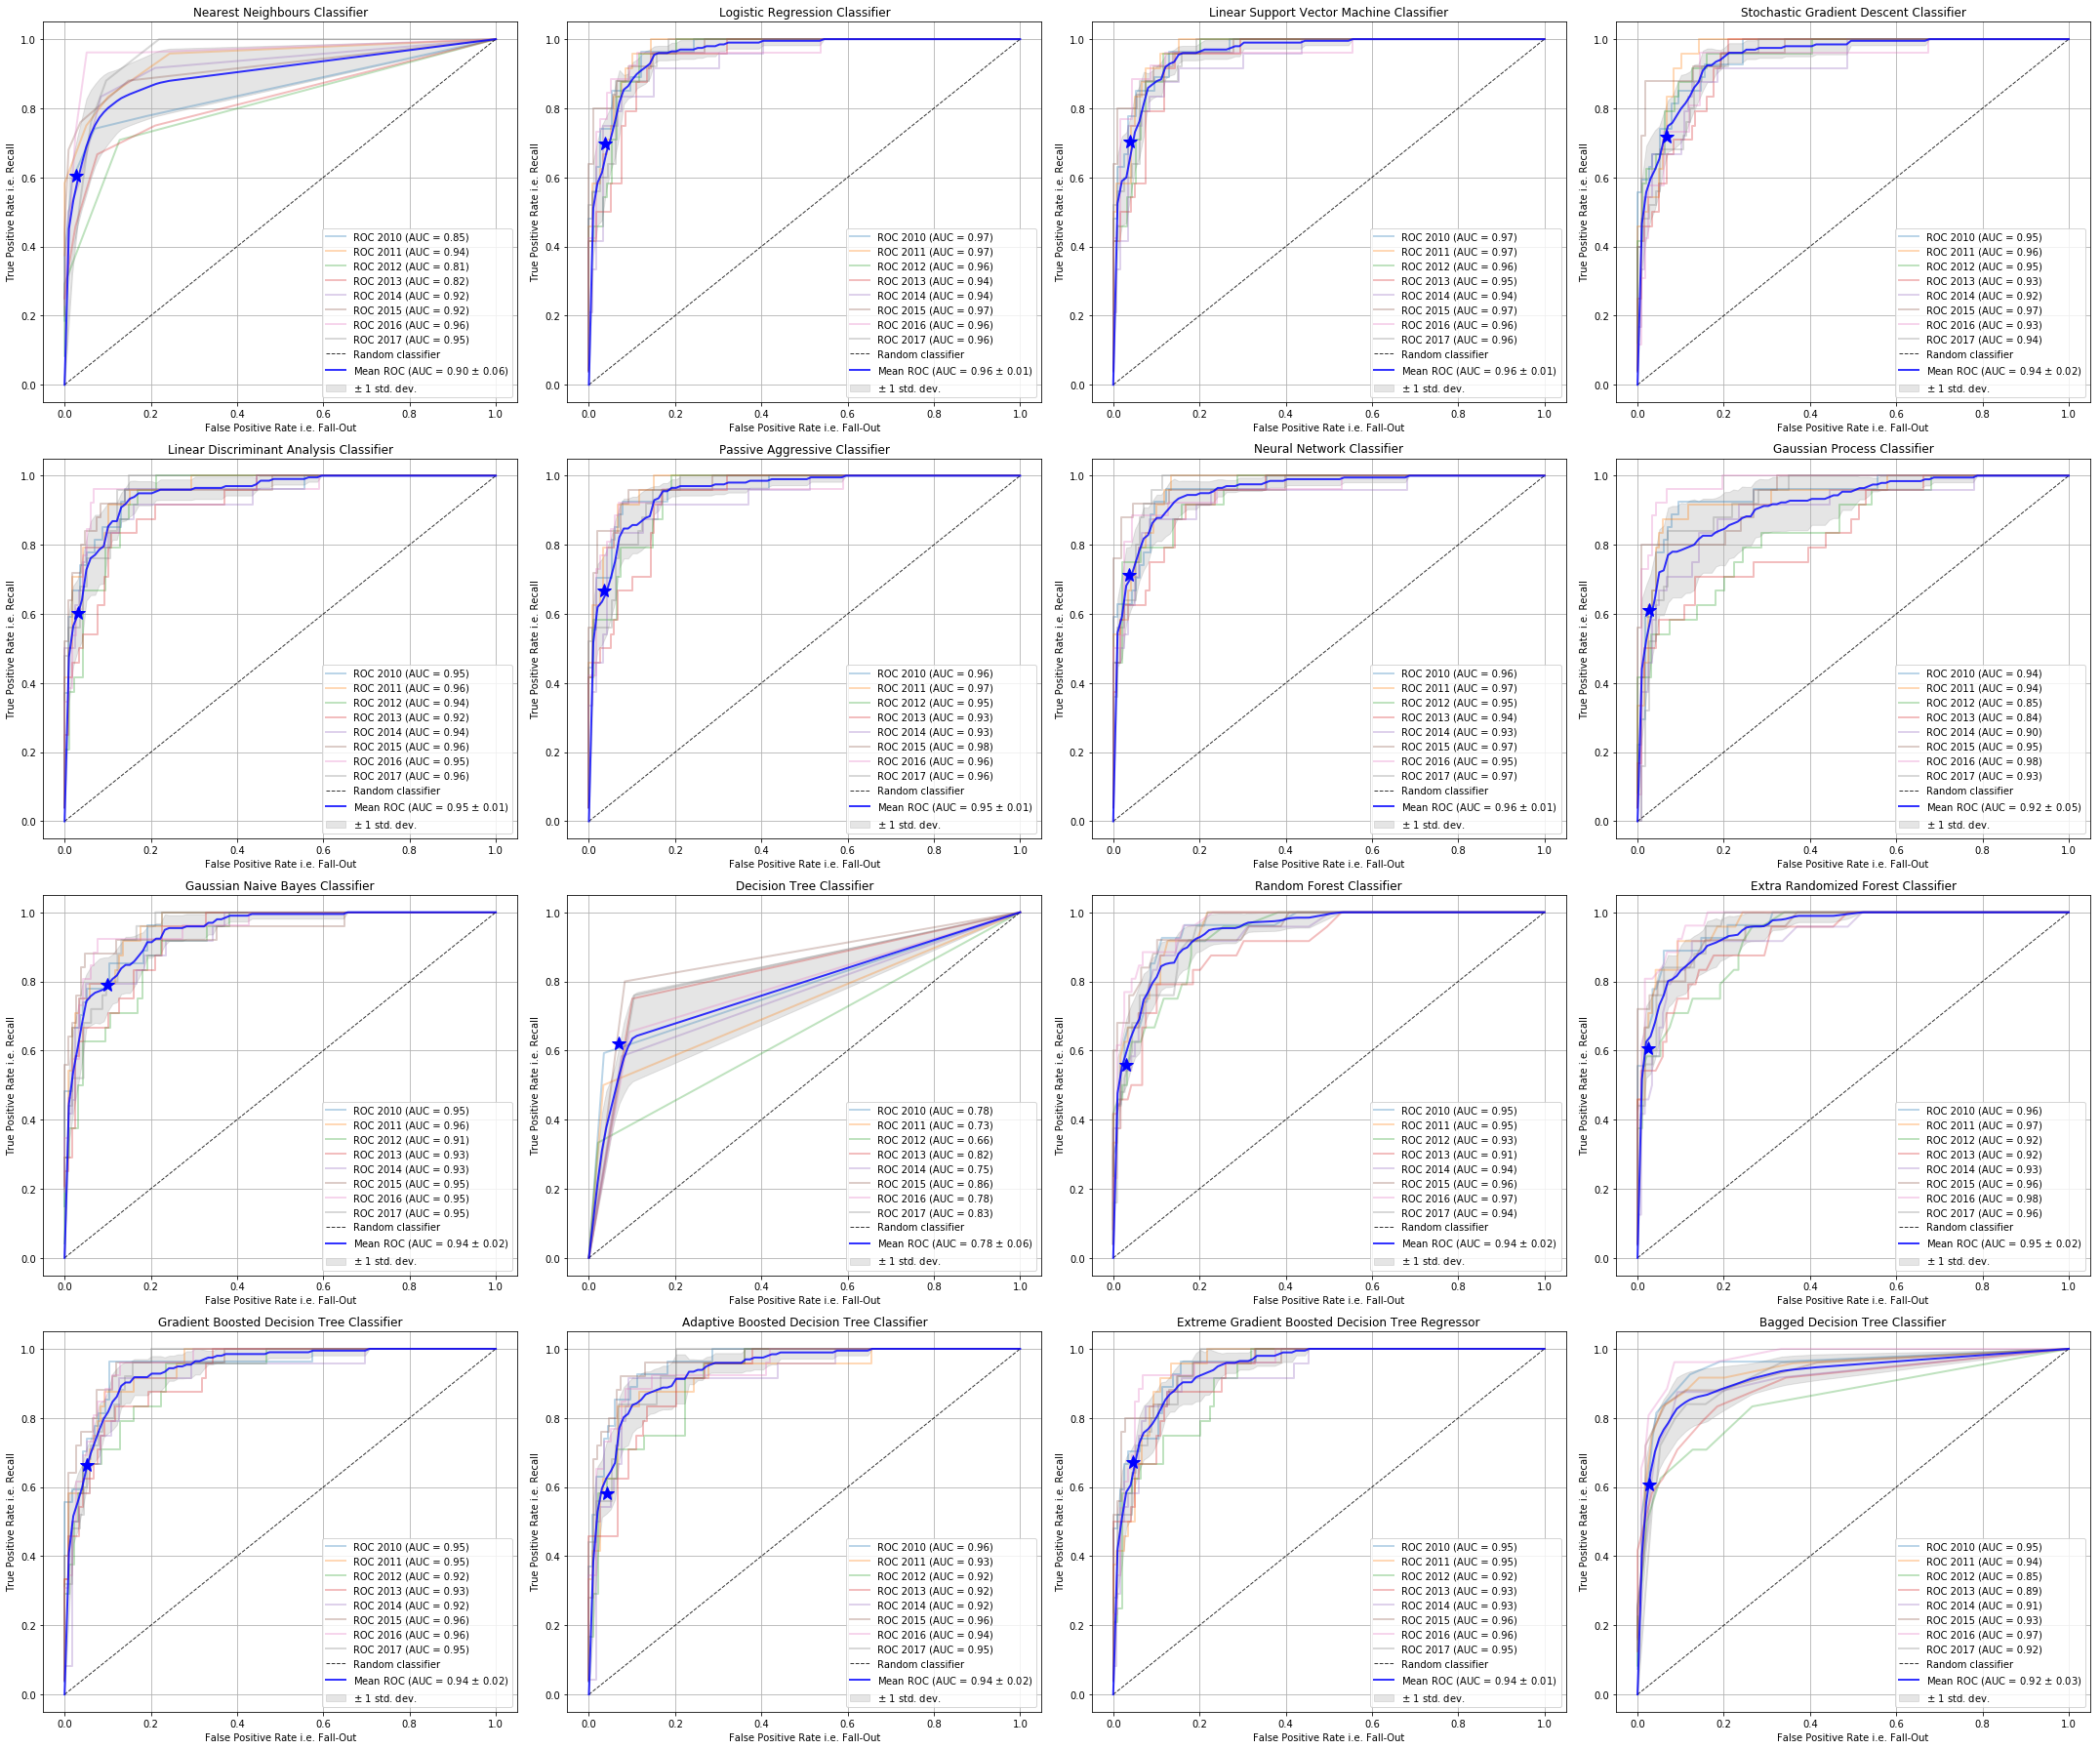

In [19]:
plt.figure(figsize=(30, 25))

for imodel, model in enumerate(models):

    plt.subplot(4, 4, imodel+1)
    
    tpr_linspaces = []
    fpr_linspace = np.linspace(0, 1, 100)
    
    for i in range(len(train_years)):
        
        tpr_linspaces.append(np.interp(fpr_linspace, model.FPR_ROC_cvgroups[i], model.TPR_ROC_cvgroups[i]))
        tpr_linspaces[-1][0] = 0.0
        plt.plot(model.FPR_ROC_cvgroups[i], model.TPR_ROC_cvgroups[i], lw=2, alpha=0.3, 
                 label="ROC {:d} (AUC = {:.2f})".format(train_years[i], model.AUC_ROC_cvgroups[i]))
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', label="Random classifier", alpha=.8)

    plt.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups), 
             marker='*', color='blue', markersize=15, zorder=20)
    
    mean_tpr_linspaces = np.mean(tpr_linspaces, axis=0)
    mean_tpr_linspaces[-1] = 1.0
    plt.plot(fpr_linspace, mean_tpr_linspaces, color='blue', lw=2, alpha=.8,
             label=r"Mean ROC (AUC = {:0.2f} $\pm$ {:0.2f})".format(np.mean(model.AUC_ROC_cvgroups), 
                                                                    np.std(model.AUC_ROC_cvgroups)))
    model.fpr_linspace       = fpr_linspace
    model.mean_tpr_linspaces = mean_tpr_linspaces
    
    std_tpr_linspaces = np.std(tpr_linspaces, axis=0)
    tpr_linspaces_upper = np.minimum(mean_tpr_linspaces + std_tpr_linspaces, 1)
    tpr_linspaces_lower = np.maximum(mean_tpr_linspaces - std_tpr_linspaces, 0)
    plt.fill_between(fpr_linspace, tpr_linspaces_lower, tpr_linspaces_upper, 
                     color='grey', alpha=.2, label=r"$\pm$ 1 std. dev.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate i.e. Fall-Out")
    plt.ylabel("True Positive Rate i.e. Recall")
    plt.title(model.estimator_name)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()

 Plot the Precision-Recall curves for all models:

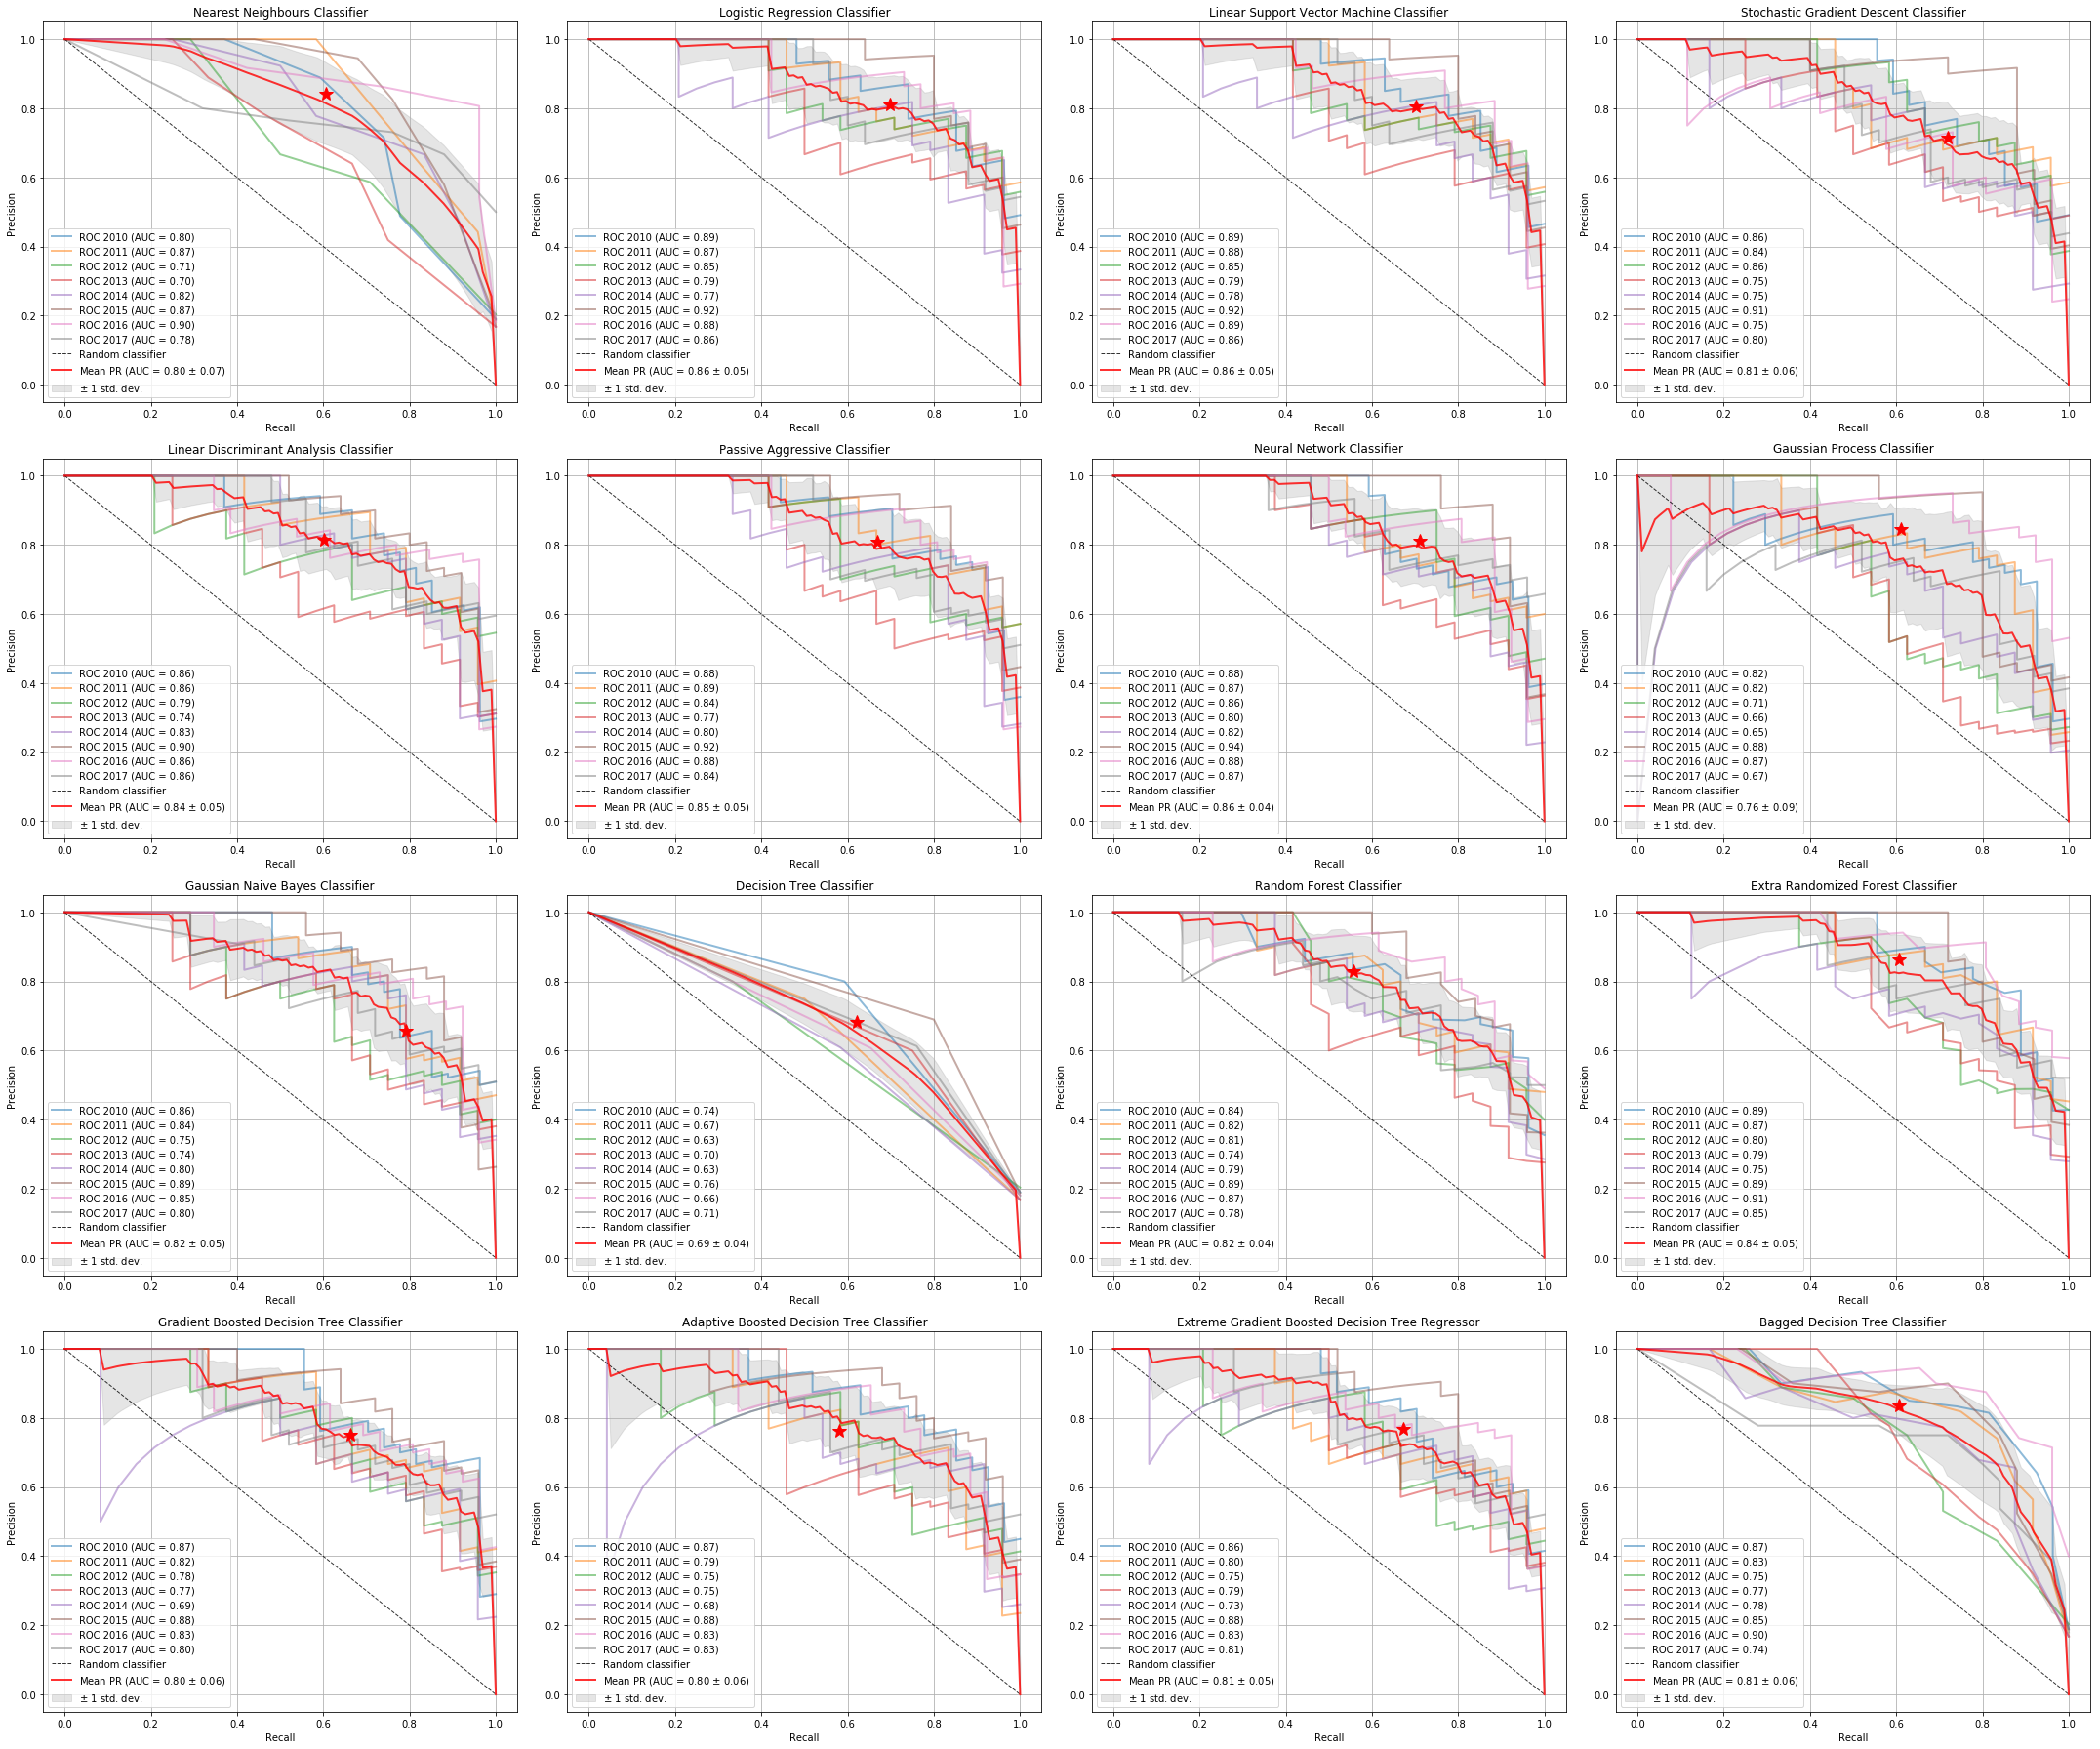

In [20]:
plt.figure(figsize=(30, 25))

for imodel, model in enumerate(models):

    plt.subplot(4, 4, imodel+1)
    
    pre_linspaces = []
    rec_linspace = np.linspace(0, 1, 100)
    
    for i in range(len(train_years)):
        
        pre_linspaces.append(np.interp(rec_linspace, model.REC_PR_cvgroups[i], model.PRE_PR_cvgroups[i]))
        pre_linspaces[-1][0] = 1.0
        plt.plot(model.REC_PR_cvgroups[i], model.PRE_PR_cvgroups[i], lw=2, alpha=0.5, 
                 label="ROC {:d} (AUC = {:.2f})".format(train_years[i], model.AUC_PR_cvgroups[i]))
        
    plt.plot([0, 1], [1, 0], linestyle='--', lw=1, color='black', label="Random classifier", alpha=.8)

    plt.plot(np.mean(model.REC_cvgroups), np.mean(model.PRE_cvgroups), 
             marker='*', color='red', markersize=15, zorder=20)
    
    mean_pre_linspaces = np.mean(pre_linspaces, axis=0)
    mean_pre_linspaces[-1] = 0.0
    plt.plot(rec_linspace, mean_pre_linspaces, color='red', lw=2, alpha=.8,
             label=r"Mean PR (AUC = {:0.2f} $\pm$ {:0.2f})".format(np.mean(model.AUC_PR_cvgroups), 
                                                                    np.std(model.AUC_PR_cvgroups)))
    model.rec_linspace       = rec_linspace
    model.mean_pre_linspaces = mean_pre_linspaces

    std_pre_linspaces = np.std(pre_linspaces, axis=0)
    pre_linspaces_upper = np.minimum(mean_pre_linspaces + std_pre_linspaces, 1)
    pre_linspaces_lower = np.maximum(mean_pre_linspaces - std_pre_linspaces, 0)
    plt.fill_between(rec_linspace, pre_linspaces_lower, pre_linspaces_upper, 
                     color='grey', alpha=.2, label=r"$\pm$ 1 std. dev.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(model.estimator_name)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()

Plot the mean ROC and PR curves for all models in single plots for comparison:

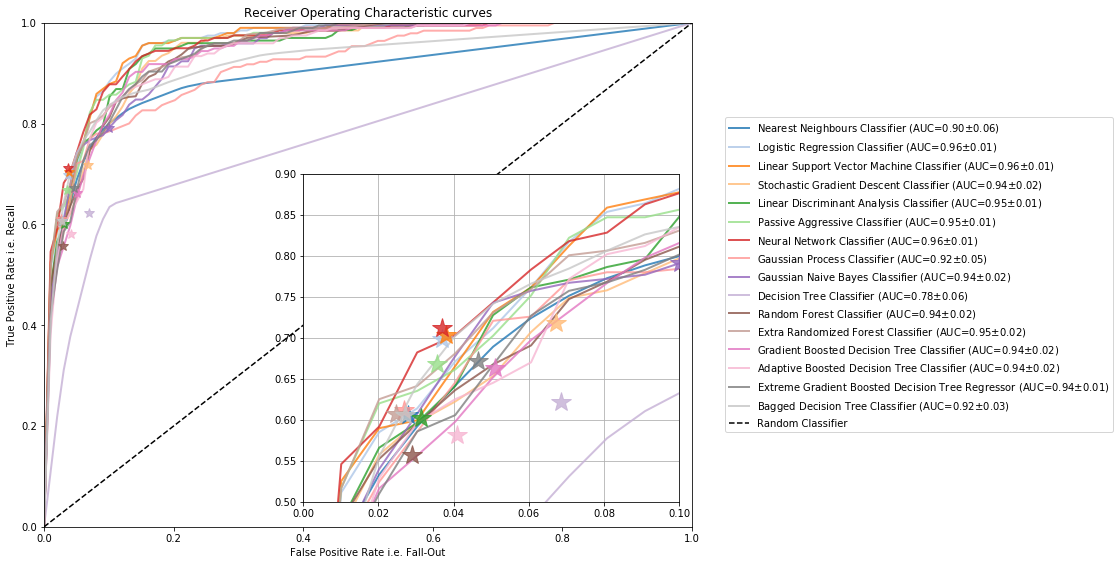

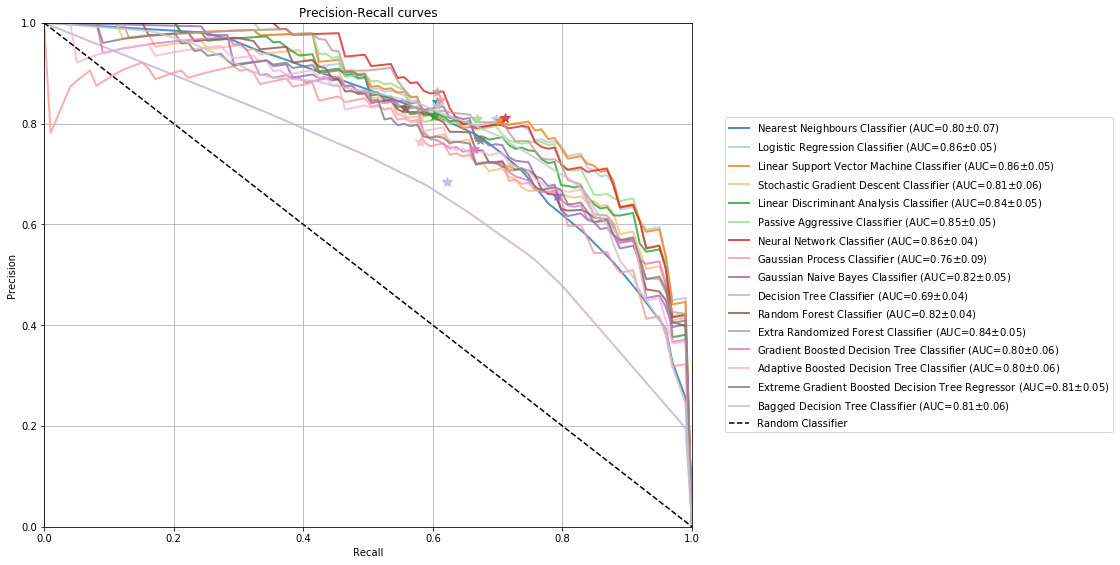

In [21]:
color = iter(plt.cm.tab20(np.linspace(0, 1, 20))) #len(models))))

fig1 = plt.figure(figsize=(9, 7))
fig2 = plt.figure(figsize=(9, 7))

ax1a = fig1.add_axes([0,0,1,1])
ax1b = fig1.add_axes([0.4, 0.05, 0.58, 0.65])
ax2  = fig2.add_axes([0,0,1,1])

for model in models:

    c=next(color)
                
    label = "{} (AUC={:.2f}$\pm${:.2f})".format(model.estimator_name, 
                                                np.mean(model.AUC_ROC_cvgroups), 
                                                np.std(model.AUC_ROC_cvgroups))
    
    ax1a.plot(model.fpr_linspace, model.mean_tpr_linspaces, color=c, lw=2, alpha=.8, label=label)
    ax1a.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups), 
              marker='*', color=c, alpha=.8, markersize=10, zorder=20)
        
    ax1b.plot(model.fpr_linspace, model.mean_tpr_linspaces, color=c, lw=2, alpha=.8, label=label)
    ax1b.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups),
              marker='*', color=c, alpha=.8, markersize=20, zorder=20)
    
    label = "{} (AUC={:.2f}$\pm${:.2f})".format(model.estimator_name, 
                                                np.mean(model.AUC_PR_cvgroups), 
                                                np.std(model.AUC_PR_cvgroups))
    
    ax2.plot(model.rec_linspace, model.mean_pre_linspaces, color=c, lw=2, alpha=.8, label=label)
    ax2.plot(np.mean(model.REC_cvgroups), np.mean(model.PRE_cvgroups),
             marker='*', color=c, alpha=.8, markersize=10, zorder=20)

ax1a.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Classifier')
ax1a.set_xlim(0, 1)
ax1a.set_ylim(0, 1)
ax1a.set_xlabel('False Positive Rate i.e. Fall-Out')
ax1a.set_ylabel('True Positive Rate i.e. Recall')
ax1a.set_title('Receiver Operating Characteristic curves')
ax1a.legend(loc='center', bbox_to_anchor=(1.35,0.5), numpoints=1)
#ax1a.grid(True)
    
ax1b.set_xlim(0.0, 0.1)
ax1b.set_ylim(0.5, 0.9)
ax1b.grid(True)

ax2.plot([0, 1], [1, 0], color='black', linestyle='--', label='Random Classifier')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall curves')
ax2.legend(loc='center', bbox_to_anchor=(1.35,0.5), numpoints=1)
ax2.grid(True)

#### Conclusion: 

The cross-validation metrics indicate that all classifiers included in this analysis are stable and have a reasonable performance, e.g. precision scores are 70-80%, recall scores are 60-70%. The only exception is perhaps the *Decision Tree Classifier*, which is slightly less powerful than the other models tested in this analysis.

In [22]:
rejected_models = [9] # i.e. DT

Calculate feature importances of all fitted Decision Tree ensemble models (e.g. Random Forest):

In [23]:
df_importances = pd.DataFrame() #index=feature_names, columns=model_names)

for model in models:
    
    if hasattr(model.estimator, "feature_importances_"):
    
        print("--> Calculating feature importances for", model.estimator_name, "...")
        
        cvimportances = model.cvimportances
        
        df_cvimportances = pd.DataFrame(cvimportances, columns=feature_names)
                        
        mean_cvimportances = np.mean(df_cvimportances, axis=0)
        std_cvimportances  = np.std (df_cvimportances, axis=0)
        
        for i in range(n_features):
            df_importances.loc[feature_names[i], model.estimator_name] = \
                "{:.2f} $\pm$ {:.2f}".format((mean_cvimportances[i]*100), (std_cvimportances[i]*100))

print("")
print("--> Feature importances of all models (mean +/- std over all CV years):")
print("")
df_importances.dropna(axis=1, how='all', inplace=True)
display(df_importances)

--> Calculating feature importances for Decision Tree Classifier ...
--> Calculating feature importances for Random Forest Classifier ...
--> Calculating feature importances for Extra Randomized Forest Classifier ...
--> Calculating feature importances for Gradient Boosted Decision Tree Classifier ...
--> Calculating feature importances for Adaptive Boosted Decision Tree Classifier ...
--> Calculating feature importances for Extreme Gradient Boosted Decision Tree Regressor ...

--> Feature importances of all models (mean +/- std over all CV years):



Decision Tree Classifier Random Forest Classifier  \
G             0.66 $\pm$ 0.31          1.31 $\pm$ 0.18   
GS            1.74 $\pm$ 0.63          1.23 $\pm$ 0.12   
MP            3.29 $\pm$ 1.32          2.61 $\pm$ 0.42   
3P            1.18 $\pm$ 0.58          1.55 $\pm$ 0.15   
3PA           2.26 $\pm$ 1.09          2.11 $\pm$ 0.21   
2P            1.78 $\pm$ 1.10          4.75 $\pm$ 0.69   
2PA           3.86 $\pm$ 2.36          3.82 $\pm$ 0.34   
FT            3.87 $\pm$ 3.05          7.04 $\pm$ 0.60   
FTA          15.45 $\pm$ 7.60          9.87 $\pm$ 0.62   
PF            2.34 $\pm$ 1.10          2.19 $\pm$ 0.26   
PER          10.48 $\pm$ 4.63         14.82 $\pm$ 0.40   
ORB%          1.39 $\pm$ 0.97          1.64 $\pm$ 0.10   
DRB%          2.37 $\pm$ 2.45          1.64 $\pm$ 0.08   
AST%         18.02 $\pm$ 1.18          2.95 $\pm$ 0.19   
STL%          1.40 $\pm$ 0.85          1.36 $\pm$ 0.13   
BLK%          0.89 $\pm$ 0.52          1.25 $\pm$ 0.21   
TOV%          0.79 $\pm$ 0.75          1.54 $\pm$ 0.15   
USG%          3.65 $\pm$ 3.14          7.78 $\pm$ 0.54   
OWS           4.85 $\pm$ 6.66          8.39 $\pm$ 1.22   
DWS           4.60 $\pm$ 1.47          4.55 $\pm$ 0.43   
OBPM          5.62 $\pm$ 2.52          4.50 $\pm$ 0.46   
DBPM          1.84 $\pm$ 0.71          1.78 $\pm$ 0.12   
VORP          3.72 $\pm$ 5.48          8.18 $\pm$ 0.85   
TW            3.95 $\pm$ 1.91          3.12 $\pm$ 0.28   

     Extra Randomized Forest Classifier  \
G                       2.02 $\pm$ 0.11   
GS                      2.33 $\pm$ 0.22   
MP                      3.00 $\pm$ 0.24   
3P                      1.79 $\pm$ 0.14   
3PA                     1.85 $\pm$ 0.08   
2P                      5.22 $\pm$ 0.34   
2PA                     6.80 $\pm$ 0.28   
FT                      7.10 $\pm$ 0.31   
FTA                     6.46 $\pm$ 0.41   
PF                      2.32 $\pm$ 0.10   
PER                    11.27 $\pm$ 0.50   
ORB%                    1.81 $\pm$ 0.09   
DRB%                    1.96 $\pm$ 0.07   
AST%                    3.36 $\pm$ 0.27   
STL%                    1.70 $\pm$ 0.11   
BLK%                    1.60 $\pm$ 0.09   
TOV%                    1.84 $\pm$ 0.11   
USG%                    6.74 $\pm$ 0.38   
OWS                     7.36 $\pm$ 0.22   
DWS                     4.45 $\pm$ 0.28   
OBPM                    5.42 $\pm$ 0.52   
DBPM                    1.96 $\pm$ 0.06   
VORP                    7.72 $\pm$ 0.52   
TW                      3.92 $\pm$ 0.27   

     Gradient Boosted Decision Tree Classifier  \
G                              2.71 $\pm$ 0.60   
GS                             1.15 $\pm$ 0.79   
MP                             5.99 $\pm$ 1.35   
3P                             4.17 $\pm$ 0.64   
3PA                            1.55 $\pm$ 0.72   
2P                             4.38 $\pm$ 1.02   
2PA                            4.95 $\pm$ 1.02   
FT                             5.95 $\pm$ 1.37   
FTA                            3.16 $\pm$ 0.64   
PF                             6.52 $\pm$ 0.98   
PER                           11.91 $\pm$ 1.64   
ORB%                           2.18 $\pm$ 0.85   
DRB%                           2.81 $\pm$ 0.76   
AST%                           5.29 $\pm$ 0.90   
STL%                           2.34 $\pm$ 0.78   
BLK%                           1.19 $\pm$ 0.52   
TOV%                           2.78 $\pm$ 0.48   
USG%                           5.24 $\pm$ 0.68   
OWS                            4.13 $\pm$ 0.70   
DWS                            6.15 $\pm$ 1.35   
OBPM                           4.40 $\pm$ 0.90   
DBPM                           2.13 $\pm$ 1.13   
VORP                           4.15 $\pm$ 0.52   
TW                             4.78 $\pm$ 1.03   

     Adaptive Boosted Decision Tree Classifier  \
G                              0.25 $\pm$ 0.66   
GS                             1.88 $\pm$ 1.83   
MP                             5.50 $\pm$ 1.73   
3P                         

Calculate feature coefficients of all fitted linear models (e.g. Logistic Regression):

In [24]:
df_coefficients = pd.DataFrame() #index=feature_names, columns=model_names)

for model in models:
    
    if hasattr(model.estimator, "coef_"):
    
        print("--> Calculating feature coefficients for", model.estimator_name, "...")
        
        cvcoefficients = model.cvcoefficients
        
        df_cvcoefficients = pd.DataFrame(cvcoefficients, columns=feature_names)
                        
        mean_cvcoefficients = np.mean(df_cvcoefficients, axis=0)
        std_cvcoefficients  = np.std (df_cvcoefficients, axis=0)
        
        for i in range(n_features):
            df_coefficients.loc[feature_names[i], model.estimator_name] = \
                "{:.2f} $\pm$ {:.2f}".format((mean_cvcoefficients[i]), (std_cvcoefficients[i]))

print("")
print("--> Feature coefficients of all models (mean +/- std over all CV years):")
df_coefficients.dropna(axis=1, how='all', inplace=True)
display(df_coefficients)

--> Calculating feature coefficients for Logistic Regression Classifier ...
--> Calculating feature coefficients for Linear Support Vector Machine Classifier ...
--> Calculating feature coefficients for Stochastic Gradient Descent Classifier ...
--> Calculating feature coefficients for Linear Discriminant Analysis Classifier ...
--> Calculating feature coefficients for Passive Aggressive Classifier ...

--> Feature coefficients of all models (mean +/- std over all CV years):


Logistic Regression Classifier Linear Support Vector Machine Classifier  \
G                  -3.46 $\pm$ 0.21                         -1.08 $\pm$ 0.08   
GS                  2.75 $\pm$ 0.16                          0.92 $\pm$ 0.08   
MP                  2.01 $\pm$ 0.34                          0.61 $\pm$ 0.11   
3P                  0.27 $\pm$ 0.38                          0.11 $\pm$ 0.15   
3PA                -0.86 $\pm$ 0.47                         -0.30 $\pm$ 0.17   
2P                 -1.13 $\pm$ 0.42                         -0.44 $\pm$ 0.17   
2PA                 0.77 $\pm$ 0.53                          0.27 $\pm$ 0.19   
FT                  0.38 $\pm$ 0.31                          0.11 $\pm$ 0.11   
FTA                -0.08 $\pm$ 0.23                         -0.02 $\pm$ 0.08   
PF                 -0.65 $\pm$ 0.07                         -0.21 $\pm$ 0.03   
PER                 2.38 $\pm$ 0.44                          0.76 $\pm$ 0.15   
ORB%               -0.87 $\pm$ 0.22                         -0.25 $\pm$ 0.07   
DRB%                0.62 $\pm$ 0.24                          0.19 $\pm$ 0.08   
AST%                0.06 $\pm$ 0.13                          0.01 $\pm$ 0.05   
STL%               -0.44 $\pm$ 0.14                         -0.13 $\pm$ 0.05   
BLK%                0.24 $\pm$ 0.10                          0.07 $\pm$ 0.04   
TOV%                0.38 $\pm$ 0.19                          0.12 $\pm$ 0.07   
USG%                0.85 $\pm$ 0.21                          0.32 $\pm$ 0.07   
OWS                -0.10 $\pm$ 0.44                          0.01 $\pm$ 0.14   
DWS                 1.31 $\pm$ 0.23                          0.40 $\pm$ 0.08   
OBPM               -0.36 $\pm$ 0.53                         -0.15 $\pm$ 0.16   
DBPM               -1.31 $\pm$ 0.42                         -0.41 $\pm$ 0.13   
VORP                0.70 $\pm$ 0.55                          0.23 $\pm$ 0.18   
TW                  1.01 $\pm$ 0.20                          0.31 $\pm$ 0.06   

     Stochastic Gradient Descent Classifier  \
G                         -26.24 $\pm$ 2.00   
GS                          8.02 $\pm$ 4.01   
MP                         12.36 $\pm$ 3.57   
3P                          3.81 $\pm$ 2.08   
3PA                         0.04 $\pm$ 1.67   
2P                          2.72 $\pm$ 2.42   
2PA                         6.54 $\pm$ 3.35   
FT                          4.76 $\pm$ 1.81   
FTA                         0.98 $\pm$ 3.51   
PF                         -9.52 $\pm$ 1.81   
PER                         9.51 $\pm$ 1.19   
ORB%                       -5.79 $\pm$ 2.29   
DRB%                        8.58 $\pm$ 2.35   
AST%                        7.56 $\pm$ 2.23   
STL%                       -0.94 $\pm$ 4.07   
BLK%                        5.43 $\pm$ 3.67   
TOV%                        4.57 $\pm$ 4.50   
USG%                        6.16 $\pm$ 3.16   
OWS                         4.46 $\pm$ 4.94   
DWS                        13.16 $\pm$ 2.51   
OBPM                       -0.54 $\pm$ 3.50   
DBPM                       -7.25 $\pm$ 1.67   
VORP                        4.83 $\pm$ 4.39   
TW                          7.94 $\pm$ 2.84   

     Linear Discriminant Analysis Classifier Passive Aggressive Classifier  
G                           -0.10 $\pm$ 0.10              -0.05 $\pm$ 0.02  
GS                          -0.16 $\pm$ 0.06               0.01 $\pm$ 0.01  
MP                          -2.12 $\pm$ 0.30              -0.02 $\pm$ 0.01  
3P                          -0.40 $\pm$ 1.03              -0.03 $\pm$ 0.01  
3PA                          1.40 $\pm$ 1.13              -0.01 $\pm$ 0.01  
2P                          -3.08 $\pm$ 0.97               0.08 $\pm$ 0.01  
2PA                          5.54 $\pm$ 0.94               0.09 $\pm$ 0.01  
FT                          -1.17 $\pm$ 0.60               0.08 $\pm$ 0.01  
FTA                          1.94 $\pm$ 0.45               0.12 $\pm$ 0.01  
PF                          -0.93 $\pm$ 0.12              

## Model training and predictions

Fit all models to training data and use fitted models to predict the NBA All-Stars from *test_year*:

In [25]:
scores_list = []

for model in models:
    
    classifier = model.estimator

    print("--> Fitting", model.estimator_name, "...")
    
    classifier.fit(X_train, y_train)          # Fit model to training data

    y_prediction = classifier.predict(X_test) # Predict test data
    model.set_y_prediction(y_prediction)
    
    if test_year_truth_is_known:

        y_truth = y_test.tolist()
        model.set_y_truth(y_truth)
    
        CM = confusion_matrix(y_truth, y_prediction) # defined as: rows -> truth, columns -> prediction
        model.set_CM(CM)
    
        scores_list.append({'Estimator' : model.estimator_name, 
                            'TP'        : model.CM.TP, 
                            'FP'        : model.CM.FP, 
                            'FN'        : model.CM.FN, 
                            'TN'        : model.CM.TN, 
                            'Precision' : model.CM.precision.round(3)*100, 
                            'Recall'    : model.CM.recall.round(3)*100, 
                            'F1'        : model.CM.f1.round(3)*100, 
                            'Accuracy'  : model.CM.accuracy.round(3)*100,
                            'FPR'       : model.CM.fpr.round(3)*100})
    
    '''
    print("")
    print("--> Confusion matrix {}:".format(test_year))
    print(CM)
    print("")

    TN = CM[0,0] # defined as: 0 = negative, 1 = positive
    FN = CM[1,0] # defined as: 0 = negative, 1 = positive
    FP = CM[0,1] # defined as: 0 = negative, 1 = positive
    TP = CM[1,1] # defined as: 0 = negative, 1 = positive

    TOT = TP + FP + FN + TN

    print("--> TP = {}, FP = {}, FN = {}, TN = {}".format(TP, FP ,FN , TN))
    print("")
    print("--> True  Positive Rate i.e. Recall   (TP/(TP+FN)) = {:5.1%}".format(TP/(TP+FN)))
    print("--> False Positive Rate i.e. Fall-Out (FP/(FP+TN)) = {:5.1%}".format(FP/(FP+TN)))
    print("")

    precision = precision_score(y_test, y_prediction)
    recall    = recall_score   (y_test, y_prediction)
    f1        = f1_score       (y_test, y_prediction)
    accuracy  = accuracy_score (y_test, y_prediction)
    
    print("--> Precision score (TP/(TP+FP)) : {:.1%}".format(precision) + note1)
    print("--> Recall score    (TP/(TP+FN)) : {:.1%}".format(recall   ) + note2)
    print("--> F1 score                     : {:.1%}".format(f1       ) + note3)
    print("--> Accuracy score ((TP+TN)/TOT) : {:.1%}".format(accuracy ) + note4)
    print("")
    '''

if test_year_truth_is_known:
    print("")
    print("--> Classification scores of all models for", test_year, ":")
    columnorder = ['Estimator', 'TP', 'FP', 'FN', 'TN', 'Precision', 'Recall', 'F1', 'Accuracy', 'FPR']
    df_scores = pd.DataFrame(scores_list, columns=columnorder)
    display(df_scores)

--> Fitting Nearest Neighbours Classifier ...
--> Fitting Logistic Regression Classifier ...
--> Fitting Linear Support Vector Machine Classifier ...
--> Fitting Stochastic Gradient Descent Classifier ...
--> Fitting Linear Discriminant Analysis Classifier ...
--> Fitting Passive Aggressive Classifier ...
--> Fitting Neural Network Classifier ...
--> Fitting Gaussian Process Classifier ...
--> Fitting Gaussian Naive Bayes Classifier ...
--> Fitting Decision Tree Classifier ...
--> Fitting Random Forest Classifier ...
--> Fitting Extra Randomized Forest Classifier ...
--> Fitting Gradient Boosted Decision Tree Classifier ...
--> Fitting Adaptive Boosted Decision Tree Classifier ...
--> Fitting Extreme Gradient Boosted Decision Tree Regressor ...
--> Fitting Bagged Decision Tree Classifier ...

--> Classification scores of all models for 2018 :


Estimator  TP  FP  FN   TN  \
0                      Nearest Neighbours Classifier  16   5  12  108   
1                     Logistic Regression Classifier  19   3   9  110   
2           Linear Support Vector Machine Classifier  19   3   9  110   
3             Stochastic Gradient Descent Classifier  15   2  13  111   
4            Linear Discriminant Analysis Classifier  16   3  12  110   
5                      Passive Aggressive Classifier  17   3  11  110   
6                          Neural Network Classifier  20   5   8  108   
7                        Gaussian Process Classifier  18   1  10  112   
8                    Gaussian Naive Bayes Classifier  20  10   8  103   
9                           Decision Tree Classifier  14   6  14  107   
10                          Random Forest Classifier  14   1  14  112   
11                Extra Randomized Forest Classifier  17   1  11  112   
12         Gradient Boosted Decision Tree Classifier  21   2   7  111   
13         Adaptive Boosted Decision Tree Classifier  19   3   9  110   
14  Extreme Gradient Boosted Decision Tree Regressor  17   2  11  111   
15                   Bagged Decision Tree Classifier  16   2  12  111   

    Precision  Recall    F1  Accuracy  FPR  
0        76.2    57.1  65.3      87.9  4.4  
1        86.4    67.9  76.0      91.5  2.7  
2        86.4    67.9  76.0      91.5  2.7  
3        88.2    53.6  66.7      89.4  1.8  
4        84.2    57.1  68.1      89.4  2.7  
5        85.0    60.7  70.8      90.1  2.7  
6        80.0    71.4  75.5      90.8  4.4  
7        94.7    64.3  76.6      92.2  0.9  
8        66.7    71.4  69.0      87.2  8.8  
9        70.0    50.0  58.3      85.8  5.3  
10       93.3    50.0  65.1      89.4  0.9  
11       94.4    60.7  73.9      91.5  0.9  
12       91.3    75.0  82.4      93.6  1.8  
13       86.4    67.9  76.0      91.5  2.7  
14       89.5    60.7  72.3      90.8  1.8  
15       88.9    57.1  69.6      90.1  1.8

Plot Confusion Matrices for all fitted models:

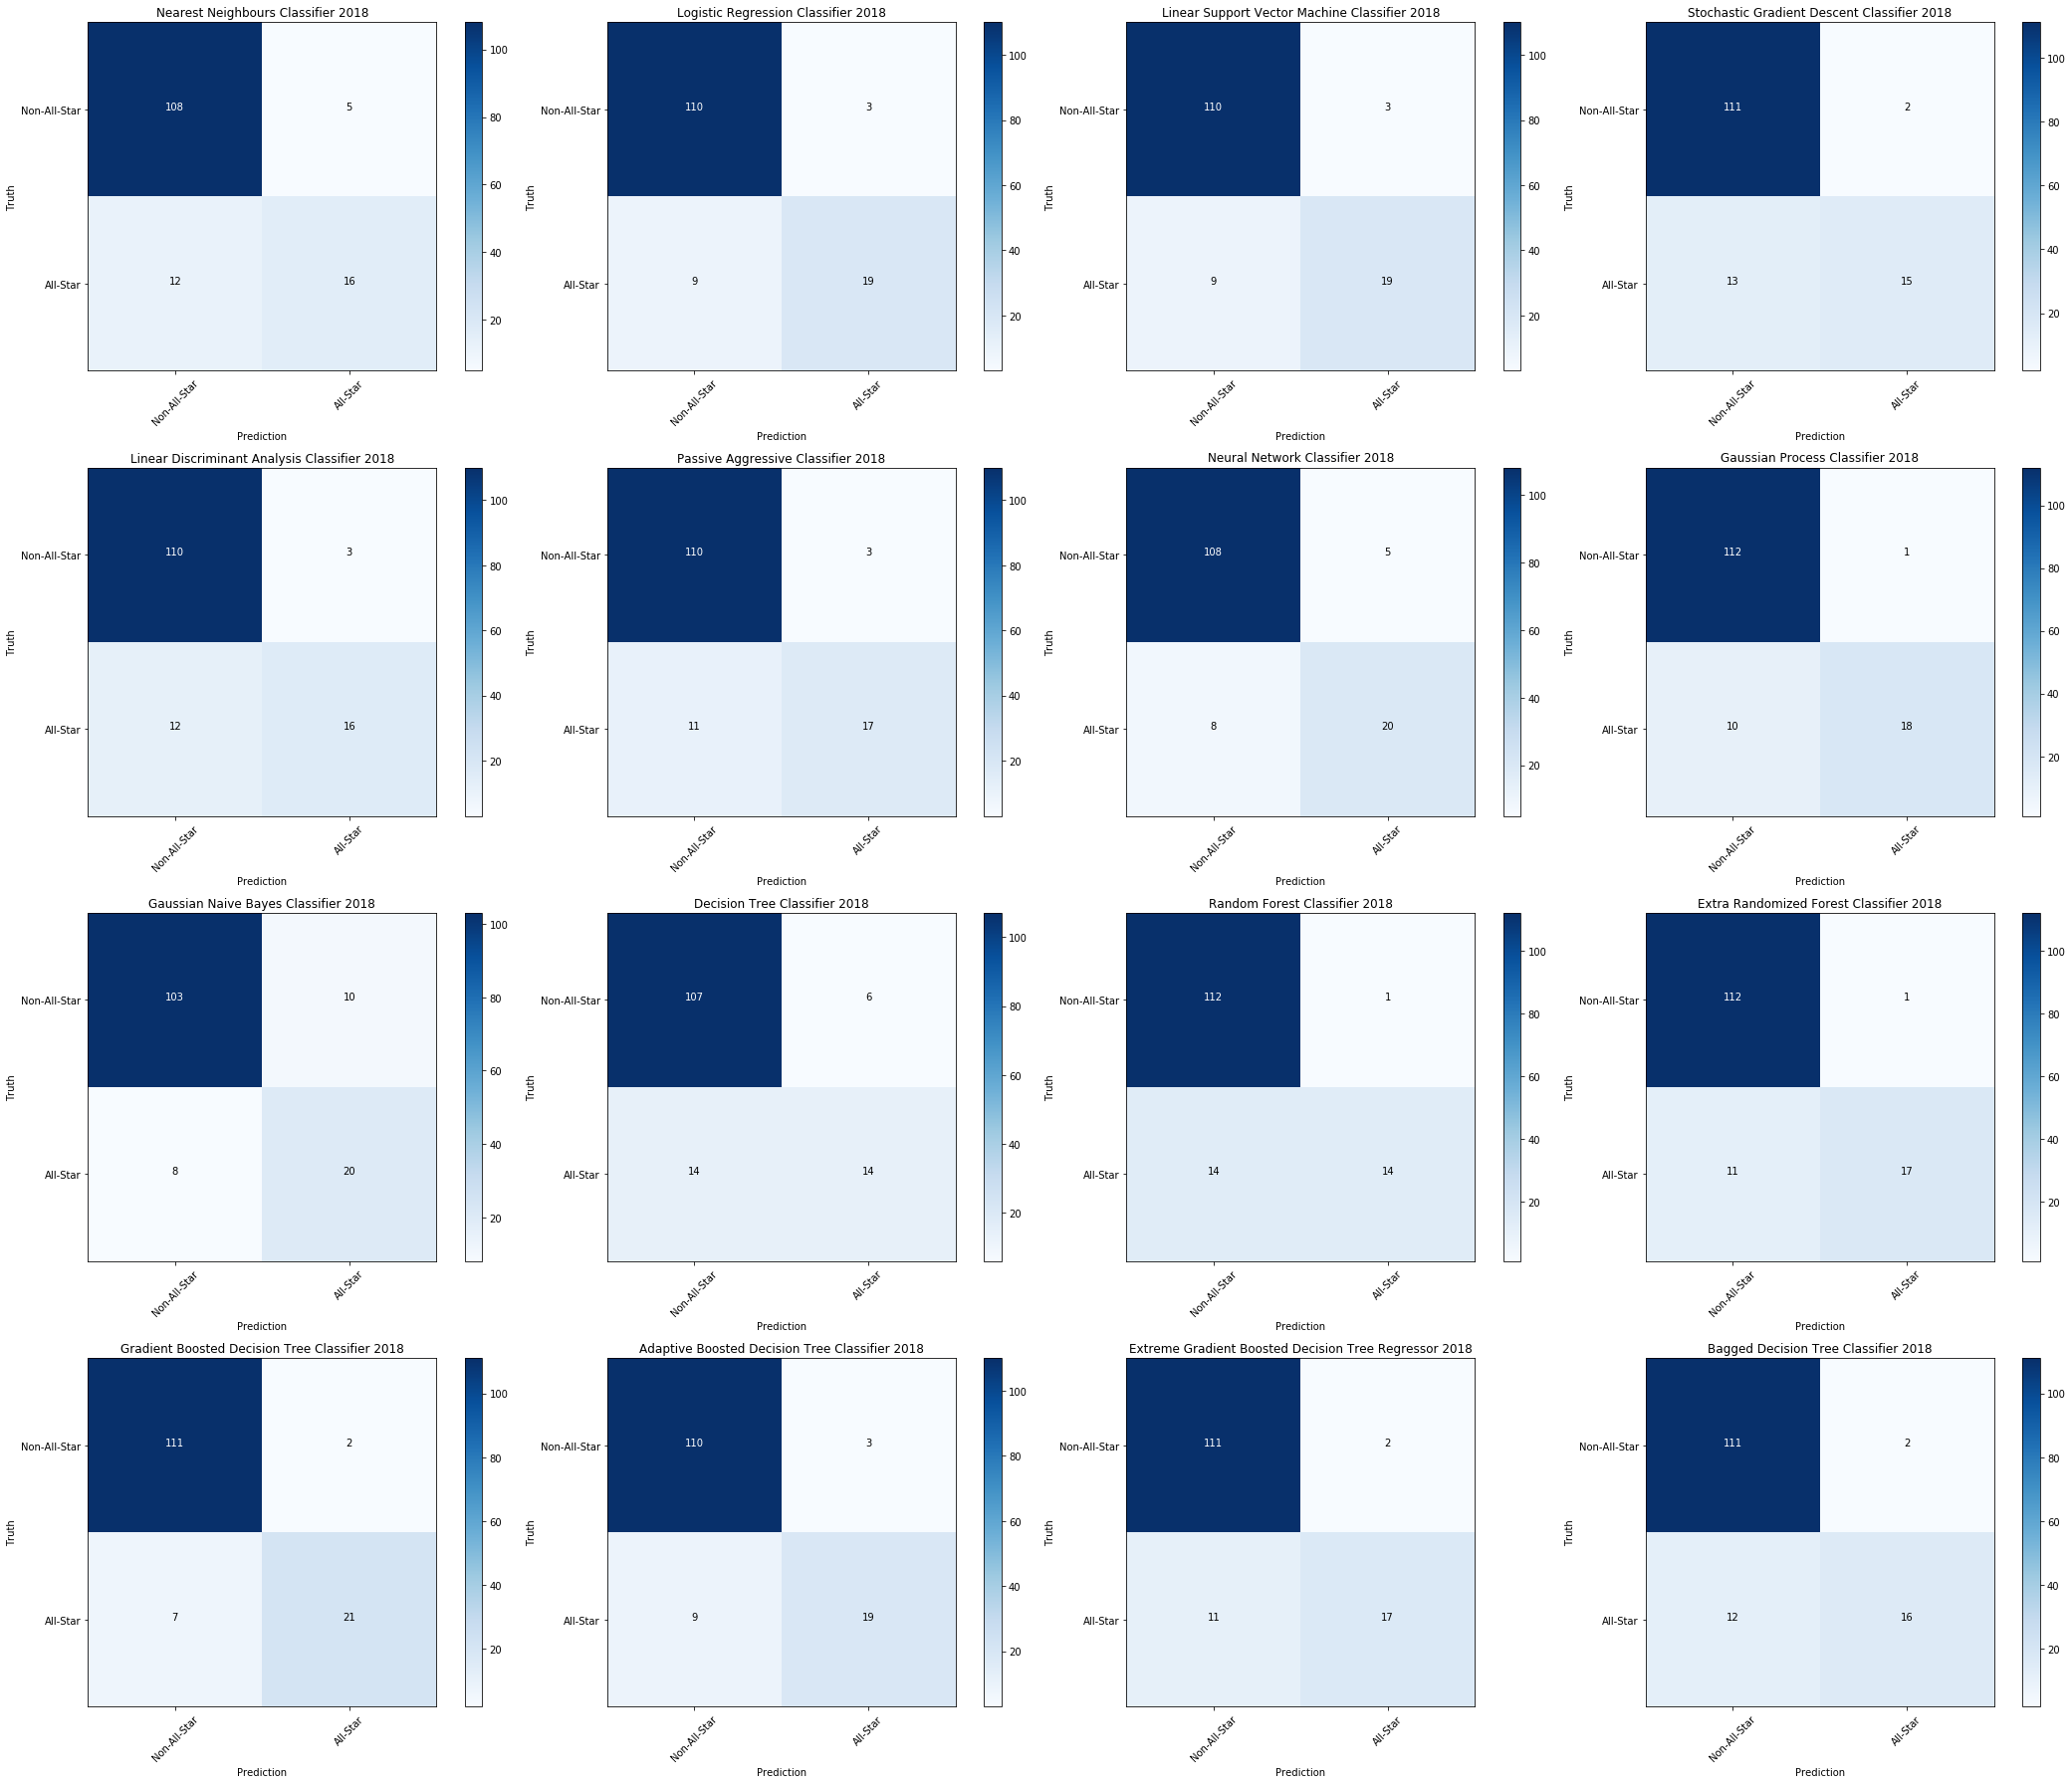

In [26]:
if test_year_truth_is_known:
    
    np.set_printoptions(precision=2)

    class_names = ['Non-All-Star','All-Star']

    plt.figure(figsize=(30, 25))

    for imodel, model in enumerate(models):

        plt.subplot(4, 4, imodel+1)
    
        CM = confusion_matrix(model.y_truth, model.y_prediction)

        NBAanalysissetup.plot_confusion_matrix(CM, classes=class_names, normalize=False,
                                               title="{} {}".format(model.estimator_name, test_year))
        plt.tight_layout()
else:
    print("--> The NBA All-Stars for {} have not been selected yet".format(print_year))

Print classification reports for all fitted models:

Calculate feature importances of all fitted Decision Tree ensemble models (e.g. Random Forest):

In [27]:
df_importances = pd.DataFrame() #index=feature_names, columns=model_names)

for model in models:

    print("--> Calculating feature importances for", model.estimator_name, "...")
    #print("")
    
    if hasattr(model.estimator, "feature_importances_"):
    
        importances = model.estimator.feature_importances_
        #indices = np.argsort(importances)[::-1]
    
        for i in range(n_features):
            #print("----> Feature importance ({:>2}) {:6} : {:.3f}".format(i + 1, feature_names[indices[i]], importances[indices[i]]))
            df_importances.loc[feature_names[i], model.estimator_name] = (importances[i]*100).round(1)
        
        #print("")
                
print("")
print("--> Feature importances of all models:")
df_importances.dropna(axis=1, how='all', inplace=True)
#display(df_importances)
cm = sns.light_palette("green", as_cmap=True)
df_importances_style = df_importances.style.background_gradient(cmap=cm, low=0, high=1, axis=0)
display(df_importances_style)

--> Calculating feature importances for Nearest Neighbours Classifier ...
--> Calculating feature importances for Logistic Regression Classifier ...
--> Calculating feature importances for Linear Support Vector Machine Classifier ...
--> Calculating feature importances for Stochastic Gradient Descent Classifier ...
--> Calculating feature importances for Linear Discriminant Analysis Classifier ...
--> Calculating feature importances for Passive Aggressive Classifier ...
--> Calculating feature importances for Neural Network Classifier ...
--> Calculating feature importances for Gaussian Process Classifier ...
--> Calculating feature importances for Gaussian Naive Bayes Classifier ...
--> Calculating feature importances for Decision Tree Classifier ...
--> Calculating feature importances for Random Forest Classifier ...
--> Calculating feature importances for Extra Randomized Forest Classifier ...
--> Calculating feature importances for Gradient Boosted Decision Tree Classifier ...
--> 

Calculate feature coefficients of all fitted linear models (e.g. Logistic Regression):

In [28]:
df_coefficients = pd.DataFrame(index=feature_names, columns=model_names)

for model in models:

    print("--> Calculating feature coefficients for", model.estimator_name, "...")
    #print("")
    
    if hasattr(model.estimator, "coef_"):
    
        coefficients = model.estimator.coef_.ravel()
    
        #for feature_name, coefficient in zip(feature_names, coefficients):
        #    print("----> Model coefficient {:6} ({:2}) = {:>6.3f}".format(feature_name, counter, coefficient))
        
        for i in range(n_features):
            df_coefficients.loc[feature_names[i], model.estimator_name] = coefficients[i].round(2)
        
        #print("")

print("")
print("--> Feature coefficients of all models:")
df_coefficients.dropna(axis=1, how='all', inplace=True)
display(df_coefficients)

--> Calculating feature coefficients for Nearest Neighbours Classifier ...
--> Calculating feature coefficients for Logistic Regression Classifier ...
--> Calculating feature coefficients for Linear Support Vector Machine Classifier ...
--> Calculating feature coefficients for Stochastic Gradient Descent Classifier ...
--> Calculating feature coefficients for Linear Discriminant Analysis Classifier ...
--> Calculating feature coefficients for Passive Aggressive Classifier ...
--> Calculating feature coefficients for Neural Network Classifier ...
--> Calculating feature coefficients for Gaussian Process Classifier ...
--> Calculating feature coefficients for Gaussian Naive Bayes Classifier ...
--> Calculating feature coefficients for Decision Tree Classifier ...
--> Calculating feature coefficients for Random Forest Classifier ...
--> Calculating feature coefficients for Extra Randomized Forest Classifier ...
--> Calculating feature coefficients for Gradient Boosted Decision Tree Classi

Logistic Regression Classifier Linear Support Vector Machine Classifier  \
G                              -3.6                                    -1.13   
GS                             2.94                                     0.99   
MP                             2.01                                     0.61   
3P                             0.25                                     0.09   
3PA                           -0.87                                    -0.29   
2P                            -1.24                                    -0.49   
2PA                            0.86                                     0.31   
FT                             0.34                                     0.09   
FTA                           -0.08                                    -0.02   
PF                            -0.65                                     -0.2   
PER                             2.4                                     0.77   
ORB%                          -0.87                                    -0.26   
DRB%                            0.6                                     0.19   
AST%                           0.04                                        0   
STL%                          -0.44                                    -0.13   
BLK%                           0.24                                     0.07   
TOV%                           0.39                                     0.13   
USG%                           0.85                                     0.33   
OWS                           -0.09                                     0.02   
DWS                            1.33                                     0.41   
OBPM                          -0.36                                    -0.15   
DBPM                          -1.32                                    -0.41   
VORP                           0.69                                     0.22   
TW                             0.98                                      0.3   

     Stochastic Gradient Descent Classifier  \
G                                    -22.79   
GS                                     3.45   
MP                                     6.73   
3P                                     7.79   
3PA                                   -0.49   
2P                                     -3.6   
2PA                                    5.45   
FT                                     3.97   
FTA                                   -3.37   
PF                                    -9.03   
PER                                   10.96   
ORB%                                  -9.55   
DRB%                                   7.13   
AST%                                   4.52   
STL%                                   2.22   
BLK%                                   0.99   
TOV%                                   3.92   
USG%                                   9.06   
OWS                                    3.49   
DWS                                   11.79   
OBPM                                  -5.37   
DBPM                                  -5.14   
VORP                                  -1.96   
TW                                     9.59   

     Linear Discriminant Analysis Classifier Passive Aggressive Classifier  
G                                      -0.11                         -0.07  
GS                                     -0.16                          0.01  
MP                                     -2.12                         -0.02  
3P                                      -0.5                         -0.02  
3PA                                     1.46                            -0  
2P                                     -3.18                          0.08  
2PA                                     5.62                          0.09  
FT                                     -1.22                          0.08  
FTA                                     1.95                          0.11  
PF                                     -0.94              

Plot Logistic Curves for each feature for the fitted Logistic Regression Classifier:

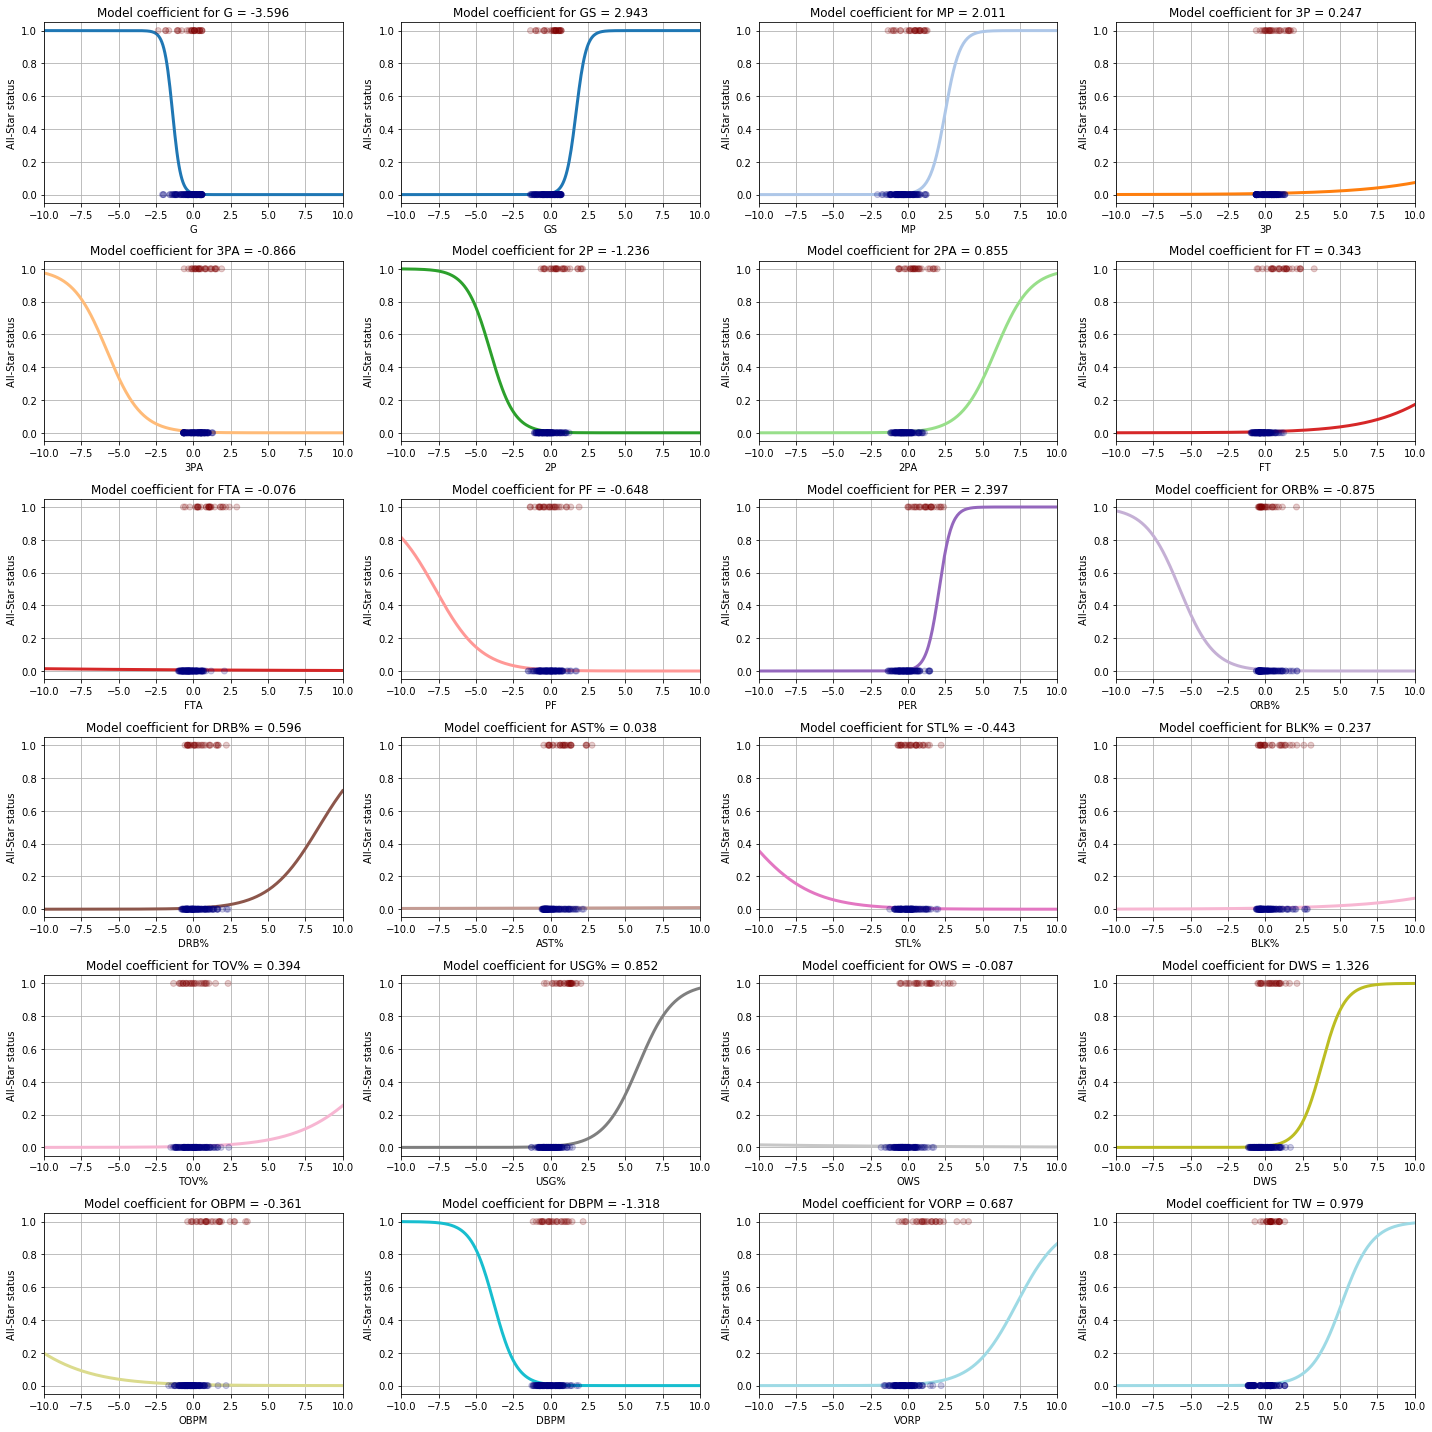

In [29]:
model = models[1].estimator # Logistic Regression Classifier

color=iter(plt.cm.tab20(np.linspace(0, 1, 24)))    

feature_linspace = np.linspace(-10, 10, 300)

plt.figure(figsize=(20, 20))

for i, (feature_name, coefficient) in enumerate(zip(feature_names, model.coef_.ravel())):
    
    plt.subplot(6, 4, i+1)

    feature_data  = X_test[:,i]
    ASstatus_data = y_test.ravel()
    
    plt.scatter(feature_data, ASstatus_data, c=ASstatus_data, cmap='jet', alpha=.2, zorder=20)
        
    logfunc = NBAanalysissetup.logistic_function(feature_linspace*coefficient + model.intercept_).ravel()

    plt.plot(feature_linspace, logfunc, color=next(color), linewidth=3, label=feature_name)

    plt.xlim([-10, 10])
    plt.ylim([-0.05, 1.05])
    plt.title("Model coefficient for {} = {:.3f}".format(feature_name, coefficient))
    plt.xlabel(feature_name)
    plt.ylabel('All-Star status')
    plt.grid(True)
    plt.tight_layout()

Plot decision function values / probability scores in 2-D feature space for all models:

Data features: G, GS, MP, 3P, 3PA, 2P, 2PA, FT, FTA, PF, PER, ORB%, DRB%, AST%, STL%, BLK%, TOV%, USG%, OWS, DWS, OBPM, DBPM, VORP, TW, PCA1, PCA2


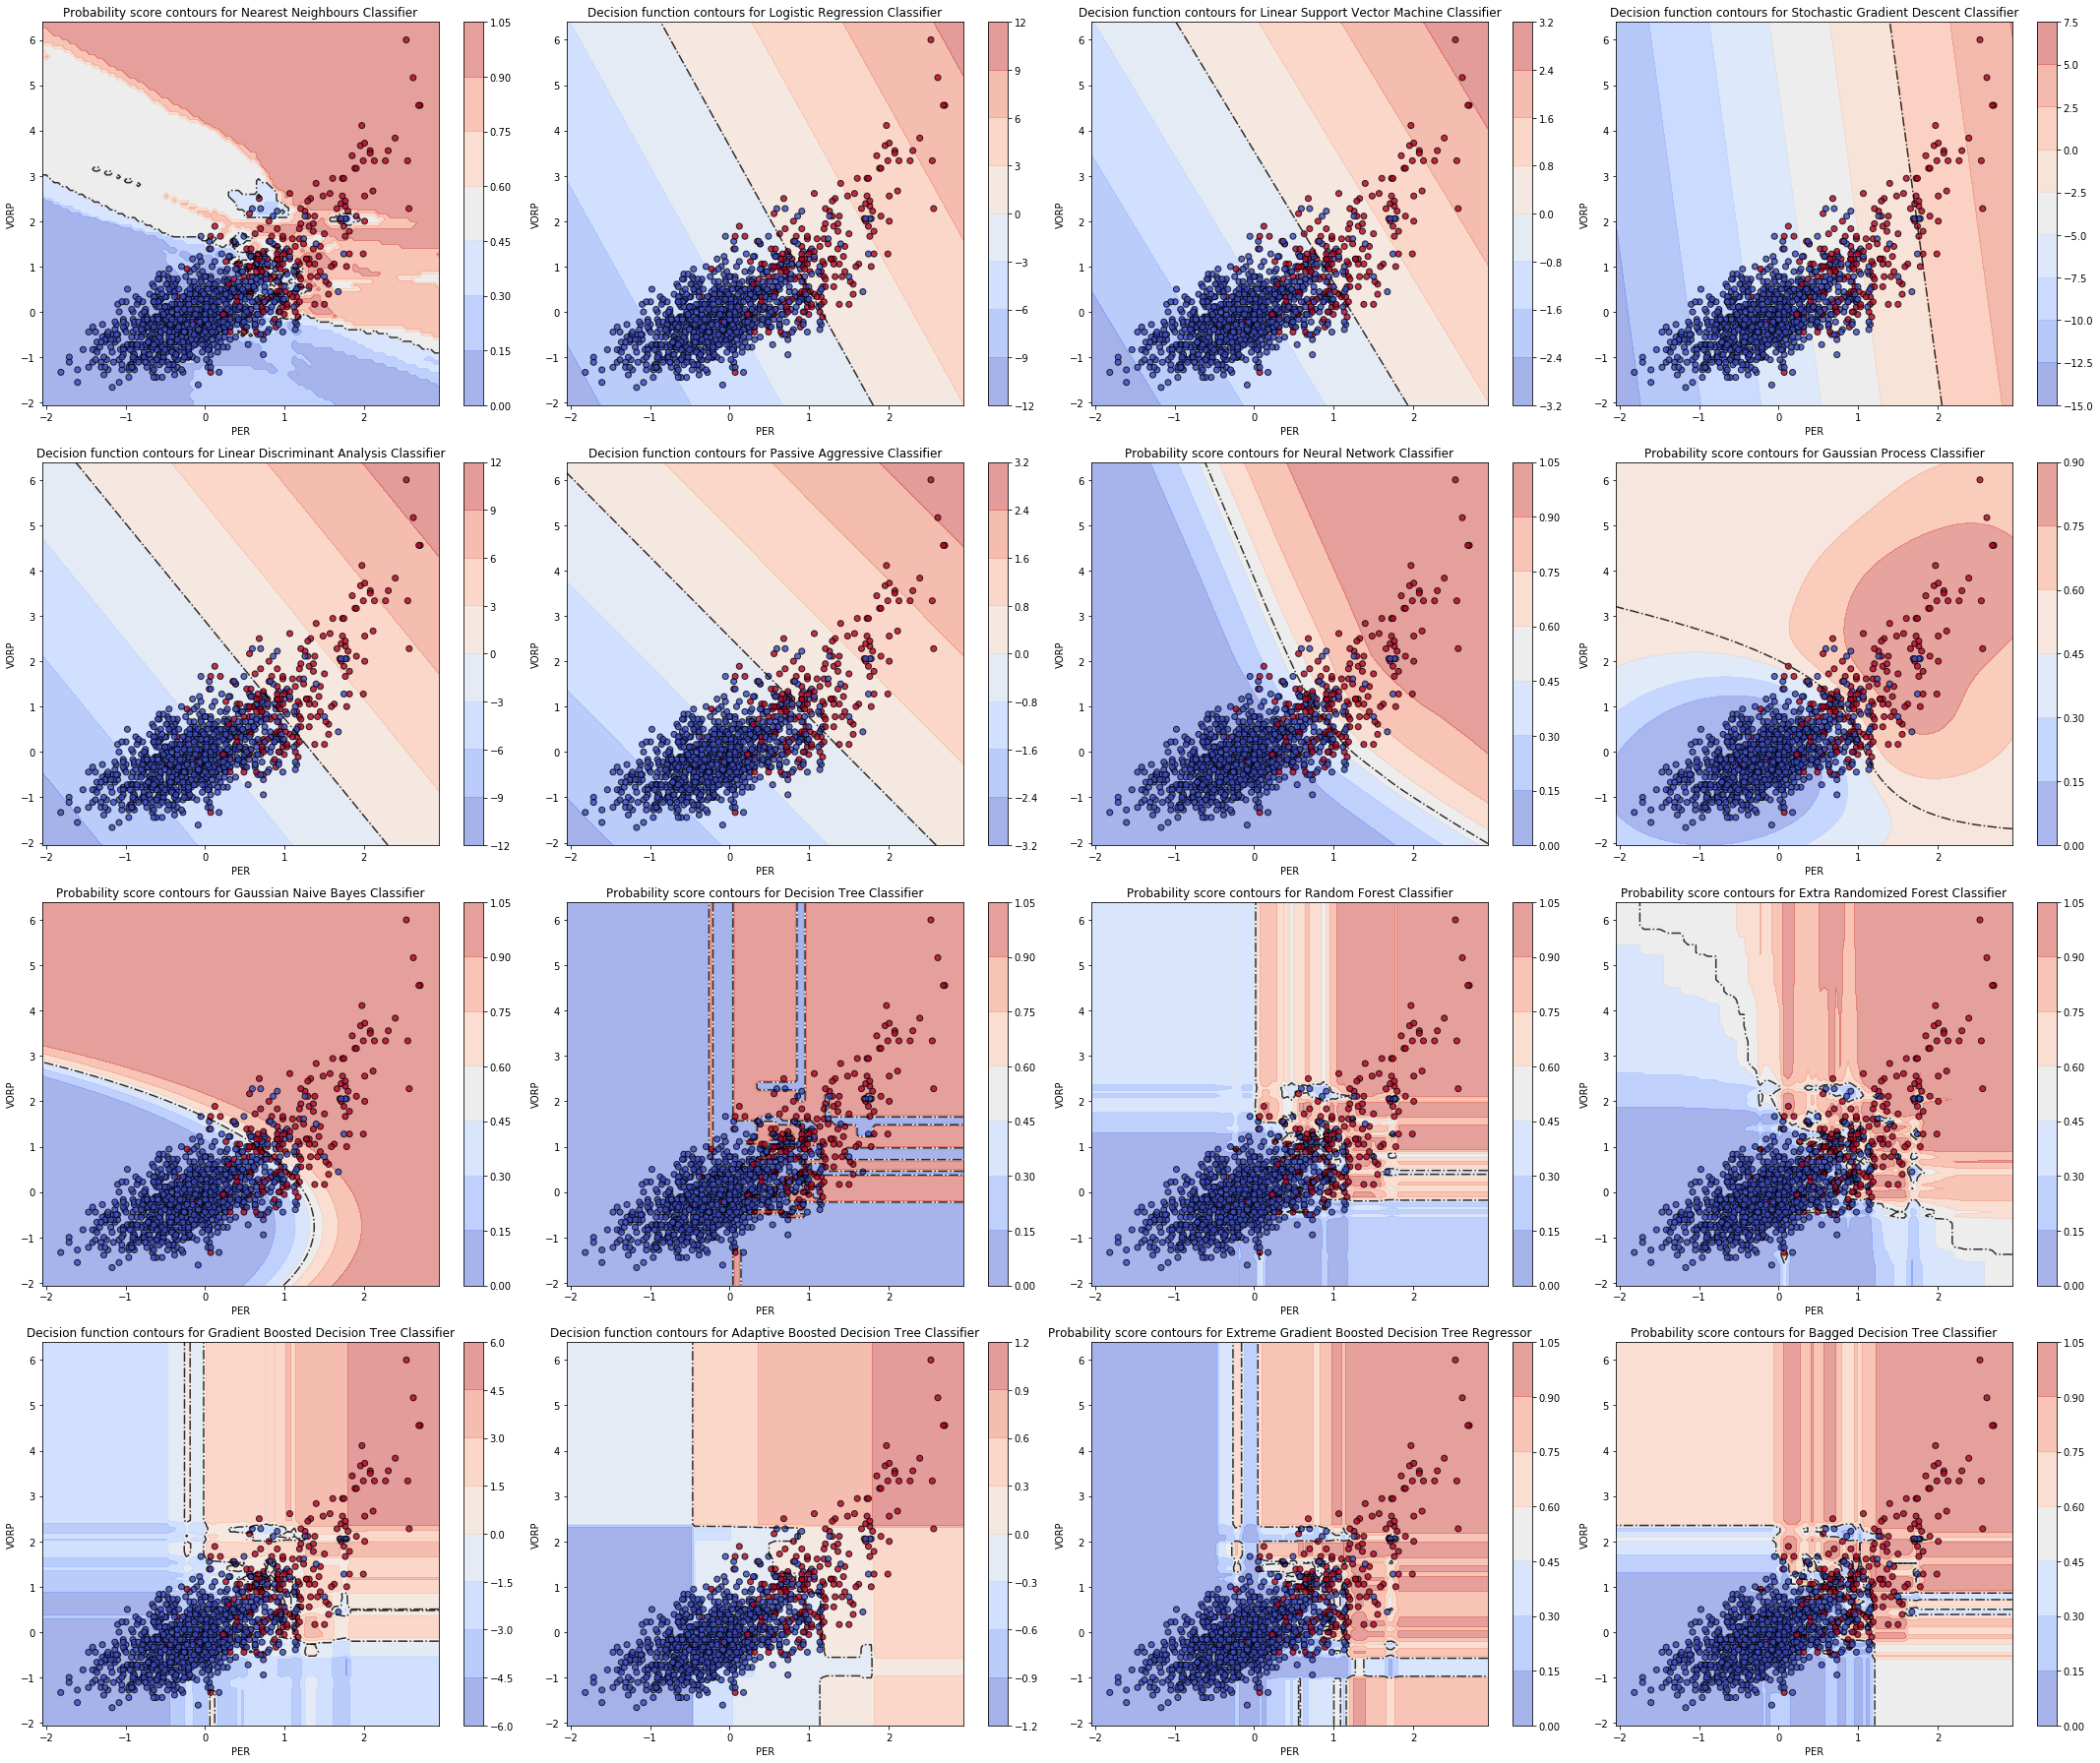

In [30]:
# Create numpy array with original data features and PCA variables:

X_tmp = np.c_[X_train, X_2D[:, 0], X_2D[:, 1]]

feature_names_list = list(feature_names)
feature_names_list.append('PCA1')
feature_names_list.append('PCA2')

# Choose two features to explore:

print("Data features: ", end='')
print(*feature_names_list, sep=", ")

if (includeadvancedstats):
    feature_x = 10 # i.e. PER
    feature_y = 22 # i.e. VORP
    #feature_x = 24 # i.e. PCA1
    #feature_y = 25 # i.e. PCA2
else:
    feature_x = 5 # i.e. 2P
    feature_y = 7 # i.e. FT
    #feature_x = 17 # i.e. PCA1
    #feature_y = 18 # i.e. PCA2

# Create 2-D array of chosen features:

X_tmp = X_tmp[:, [feature_x, feature_y]]

# Loop over all models:

plt.figure(figsize=(30,25))

colormap = plt.cm.coolwarm

for i, model in enumerate(models, 1):

    plt.subplot(4, 4, i)    
    
    # Create a copy of the classifier, and fit using 2-D features array:
        
    classifier = copy.deepcopy(model.estimator)

    classifier.fit(X_tmp, y_train)

    # Plot data:
    
    plt.scatter(X_tmp[:, 0], X_tmp[:, 1], c=y_train, 
                cmap=colormap, edgecolors='k', marker='o', alpha=0.8)

    # Create grid to calculate the decision function / probability score of the model:

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 100)
    yy = np.linspace(ylim[0], ylim[1], 100)
    YY, XX = np.meshgrid(yy, xx)
    if hasattr(classifier, "decision_function"):
        Z = classifier.decision_function(np.c_[XX.ravel(), YY.ravel()])
        title = "Decision function contours for {}".format(model.estimator_name)
        boundary = 0
    else:
        Z = classifier.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:, 1]
        title = "Probability score contours for {}".format(model.estimator_name)
        boundary = 0.5
    Z = Z.reshape(XX.shape)
    
    # Plot decision function contours and boundary:

    cf = plt.contourf(XX, YY, Z, cmap=colormap, alpha=.5, zorder=0)
    plt.colorbar(cf)
    plt.contour(XX, YY, Z, colors='black', levels=[boundary], alpha=0.8, linestyles=['-.'])

    plt.title(title)
    plt.xlabel(feature_names_list[feature_x])
    plt.ylabel(feature_names_list[feature_y])
    plt.tight_layout()

Check which players are All-Stars according to each fitted model:

In [31]:
for model in models:

    y_prediction = model.y_prediction
    y_truth      = model.y_truth
    
    print("==> Checking which players are All-Stars in {} according to {} ...".format(test_year, 
                                                                                      model.estimator_name))
    print("")

    TN_players = []
    FP_players = []
    FN_players = []
    TP_players = []
    
    for i in range(n_players_test):
    
        player_name = df_test.iat[i,0] # 0-th column in df is player name
    
        if ((y_truth[i] == 0) and (y_prediction[i] == 0)):   # TN
            TN_players.append(player_name)
        elif ((y_truth[i] == 0) and (y_prediction[i] == 1)): # FP
            FP_players.append(player_name)
        elif ((y_truth[i] == 1) and (y_prediction[i] == 0)): # FN
            FN_players.append(player_name)
        else:                                                # TP
            TP_players.append(player_name)
        
    print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
    print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
    print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
    print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
    print("")
    print("--> Deserved All-Stars     : ", end='')
    print(*TP_players, sep=', ')
    print("")
    print("--> Questionable All-Stars : ", end='')
    print(*FN_players, sep=', ')
    print("")
    print("--> Snubbed non-All-Stars  : ", end='')
    print(*FP_players, sep=', ')
    print("")

==> Checking which players are All-Stars in 2018 according to Nearest Neighbours Classifier ...

--> # of     All-Stars predicted to be     All-Stars =  16 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  12 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   5 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 108 (TN)

--> Deserved All-Stars     : LaMarcus Aldridge, Giannis Antetokounmpo, Jimmy Butler, DeMarcus Cousins, Anthony Davis, DeMar DeRozan, Kevin Durant, Joel Embiid, James Harden, Kyrie Irving, LeBron James, Damian Lillard, Kyle Lowry, Victor Oladipo, Karl-Anthony Towns, Russell Westbrook

--> Questionable All-Stars : Bradley Beal, Stephen Curry, Goran Dragic, Andre Drummond, Paul George, Draymond Green, Al Horford, Kevin Love, Kristaps Porzingis, Klay Thompson, Kemba Walker, John Wall

--> Snubbed non-All-Stars  : Clint Capela, Blake Griffin, Nikola Jokic, Chris Paul, Ben Simmons

==> Checking which players are All-Stars in 2018 according to L

## Ensemble model

Create an ensemble model from ML classifier list using *VotingClassifier* class with majority voting:

In [32]:
print("--> Classifiers included in the ensemble model:")
print("")

classification_algs = []

for imodel, model in enumerate(models, 0):
    if imodel in rejected_models:
        continue
    print("-----> {:2} : {}".format(imodel, model.estimator_name))
    clf_tuple = (model.estimator_name, model.estimator)
    classification_algs.append(clf_tuple)
    
ensemble = VotingClassifier(estimators=classification_algs, voting='hard')

--> Classifiers included in the ensemble model:

----->  0 : Nearest Neighbours Classifier
----->  1 : Logistic Regression Classifier
----->  2 : Linear Support Vector Machine Classifier
----->  3 : Stochastic Gradient Descent Classifier
----->  4 : Linear Discriminant Analysis Classifier
----->  5 : Passive Aggressive Classifier
----->  6 : Neural Network Classifier
----->  7 : Gaussian Process Classifier
----->  8 : Gaussian Naive Bayes Classifier
-----> 10 : Random Forest Classifier
-----> 11 : Extra Randomized Forest Classifier
-----> 12 : Gradient Boosted Decision Tree Classifier
-----> 13 : Adaptive Boosted Decision Tree Classifier
-----> 14 : Extreme Gradient Boosted Decision Tree Regressor
-----> 15 : Bagged Decision Tree Classifier


Cross-validate ensemble model:

In [33]:
note1 = " (Answers the question: How many predicted All-Stars are true All-Stars?)"
note2 = " (Answers the question: How many true All-Stars have been predicted?)"
note3 = " (i.e. the harmonic mean of Precision and Recall)"
note4 = " (Answers the question: How many AS and non-AS have been correctly predicted?)"

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

scoring_list = ['precision', 'recall', 'f1', 'accuracy']

rts = False

scores = cross_validate(ensemble, X_train, y_train, cv=cv_logo, scoring=scoring_list, return_train_score=rts) #, n_jobs=-1)

print("--> Total fit   time = {:5.1f} secs".format(scores['fit_time'  ].sum()))
print("--> Total score time = {:5.1f} secs".format(scores['score_time'].sum()))
print("")    
print("--> Cross-val years  :", ["{:6d}".format(yr) for yr in train_years])
print("")
print("--> Precision scores :", ["{:6.1%}".format(i) for i in scores['test_precision']])
print("--> Recall    scores :", ["{:6.1%}".format(i) for i in scores['test_recall'   ]])
print("--> F1        scores :", ["{:6.1%}".format(i) for i in scores['test_f1'       ]])
print("--> Accuracy  scores :", ["{:6.1%}".format(i) for i in scores['test_accuracy' ]])
print("")
print("--> Precision score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_precision']), 
                                                         np.std (scores['test_precision'])) + note1)
print("--> Recall    score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_recall'   ]), 
                                                         np.std (scores['test_recall'   ])) + note2)
print("--> F1 score        : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_f1'       ]), 
                                                         np.std (scores['test_f1'       ])) + note3)
print("--> Accuracy score  : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_accuracy' ]), 
                                                         np.std (scores['test_accuracy' ])) + note4)

--> Total fit   time =  44.6 secs
--> Total score time =   2.8 secs

--> Cross-val years  : ['  2010', '  2011', '  2012', '  2013', '  2014', '  2015', '  2016', '  2017']

--> Precision scores : [' 89.5%', ' 75.0%', ' 91.7%', ' 70.0%', ' 72.7%', ' 95.0%', ' 87.0%', ' 76.0%']
--> Recall    scores : [' 63.0%', ' 75.0%', ' 45.8%', ' 58.3%', ' 66.7%', ' 76.0%', ' 76.9%', ' 76.0%']
--> F1        scores : [' 73.9%', ' 75.0%', ' 61.1%', ' 63.6%', ' 69.6%', ' 84.4%', ' 81.6%', ' 76.0%']
--> Accuracy  scores : [' 91.5%', ' 91.6%', ' 88.1%', ' 88.8%', ' 90.2%', ' 94.7%', ' 93.7%', ' 91.4%']

--> Precision score : 82.1% +/-  9.1% (Answers the question: How many predicted All-Stars are true All-Stars?)
--> Recall    score : 67.2% +/- 10.4% (Answers the question: How many true All-Stars have been predicted?)
--> F1 score        : 73.2% +/-  7.6% (i.e. the harmonic mean of Precision and Recall)
--> Accuracy score  : 91.3% +/-  2.1% (Answers the question: How many AS and non-AS have been correctly 

Fit ensemble to training data and check which players are All-Stars according to the ensemble model:

In [34]:
ensemble.fit(X_train, y_train)          # Fit ensemble to training data

y_prediction = ensemble.predict(X_test) # Use fitted ensemble on prediction data

y_truth = y_test.tolist()

TN_players = []
FP_players = []
FN_players = []
TP_players = []
    
for i in range(n_players_test):
    
    player_name = df_test.iat[i, 0] # 0-th column in df is player name
    
    if ((y_truth[i] == 0)   and (y_prediction[i] == 0)): # TN
        TN_players.append(player_name)
    elif ((y_truth[i] == 0) and (y_prediction[i] == 1)): # FP
        FP_players.append(player_name)
    elif ((y_truth[i] == 1) and (y_prediction[i] == 0)): # FN
        FN_players.append(player_name)
    else:                                                # TP
        TP_players.append(player_name)
        
print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
print("")
print("--> Deserved All-Stars     : ", end='')
print(*TP_players, sep=', ')
print("")
print("--> Questionable All-Stars : ", end='')
print(*FN_players, sep=', ')
print("")
print("--> Snubbed non-All-Stars  : ", end='')
print(*FP_players, sep=', ')

--> # of     All-Stars predicted to be     All-Stars =  17 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  11 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   3 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 110 (TN)

--> Deserved All-Stars     : LaMarcus Aldridge, Giannis Antetokounmpo, Jimmy Butler, DeMarcus Cousins, Stephen Curry, Anthony Davis, DeMar DeRozan, Kevin Durant, Joel Embiid, James Harden, Kyrie Irving, LeBron James, Damian Lillard, Victor Oladipo, Karl-Anthony Towns, Kemba Walker, Russell Westbrook

--> Questionable All-Stars : Bradley Beal, Goran Dragic, Andre Drummond, Paul George, Draymond Green, Al Horford, Kevin Love, Kyle Lowry, Kristaps Porzingis, Klay Thompson, John Wall

--> Snubbed non-All-Stars  : Nikola Jokic, Chris Paul, Ben Simmons


Check classification results per classifier in the ensemble model:

In [35]:
AS_index = 51 if includeadvancedstats else 31 # AS index in dataframe

player_index_dict = {}
player_AS_dict    = {}
for i in range(n_players_test):
    player_name = df_test.iat[i, 0]
    player_index_dict[player_name] = i
    if df_test.iat[i, AS_index] > 0.5:
        player_AS_dict[player_name] = 'All-Star'
    else:
        player_AS_dict[player_name] = 'Non-All-Star'

y_classification = ensemble.transform(X_test) # Class labels predicted per classifier in ensemble

player_scores_dict    = {}
player_sumscores_dict = {}
        
for i in range(n_players_test):
    
    classification_list = y_classification[i]
    classification_sum  = np.sum(classification_list)
    player_name = df_test.iat[i, 0]
    player_scores_dict   [player_name] = classification_list
    player_sumscores_dict[player_name] = classification_sum

sorted_player_sumscores_dict = sorted(player_sumscores_dict.items(), key=operator.itemgetter(1), reverse=True)

print("--> Sum of ML classifiers for top-50 players in {}:".format(test_year))
print("")

printed_line = False
for i, (key, value) in enumerate(dict(sorted_player_sumscores_dict[:50]).items(), 1):
    if (value <= ((len(models)-len(rejected_models))/2) and not printed_line):
        print("***********************************************************************************")
        printed_line = True
    print("--> {:3}: {:24} = {:2d} {} ({})".format(i, key, value, player_scores_dict[key], player_AS_dict[key]))

--> Sum of ML classifiers for top-50 players in 2018:

-->   1: Jimmy Butler             = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   2: Anthony Davis            = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   3: Kevin Durant             = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   4: Joel Embiid              = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   5: James Harden             = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   6: LeBron James             = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   7: Damian Lillard           = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   8: Victor Oladipo           = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->   9: Russell Westbrook        = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->  10: LaMarcus Aldridge        = 14 [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->  11: Giannis Antetokounmpo    = 14 [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1] (All-Star)
-->  12: DeMar DeRozan            = 14 [1 1

## Final prediction

Calculate prediction scores for all models, and add scores and corresponding ranks to test dataframe:

In [36]:
for imodel, model in enumerate(models):
        
    column_name_score = 'CLF{}_score'.format(imodel)
    column_name_rank  = 'CLF{}_rank' .format(imodel)
    df_rank = pd.DataFrame(columns=['Player', column_name_rank], index=range(0,n_players_test))

    printlimit = 40
    
    print("==> Model scores for top-{} players in {} according to {}:".format(printlimit, test_year, model.estimator_name))
    print("")

    classifier = model.estimator

    '''
    if hasattr(classifier, "predict_proba"):
        y_score = classifier.predict_proba(X_test)
        df_test[column_name_score] = y_score[:,1]
    else:
        y_score = classifier.decision_function(X_test)
        df_test[column_name_score] = y_score[:]
    '''
    if hasattr(classifier, 'decision_function'):
        y_score = classifier.decision_function(X_test)
        df_test[column_name_score] = y_score[:]
    else:
        y_score = classifier.predict_proba(X_test)
        df_test[column_name_score] = y_score[:,1]

    player_score_dict = {}    
    for i in range(n_players_test):
        '''
        if hasattr(classifier, "predict_proba"):
            player_score_dict[df_test.iat[i,0]] = y_score[i].ravel()[1]
        else:
            player_score_dict[df_test.iat[i,0]] = y_score[i].ravel()[0]
        '''
        if hasattr(classifier, 'decision_function'):
            player_score_dict[df_test.iat[i,0]] = y_score[i].ravel()[0]
        else:
            player_score_dict[df_test.iat[i,0]] = y_score[i].ravel()[1]
            
    sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    printed_line = False
    
    previous_rank  = 0
    previous_score = 1e10
    rank_increment = 0
    
    for i, (key, value) in enumerate(dict(sorted_player_score_dict).items(), 1):
        
        if (value < previous_score):
            rank = previous_rank + 1 + rank_increment
            rank_increment = 0
        else:
            rank = previous_rank
            rank_increment += 1
        previous_rank  = rank
        previous_score = value
        
        df_rank.loc[player_index_dict[key], 'Player'        ] = key
        df_rank.loc[player_index_dict[key], column_name_rank] = rank
        
        if (i <= printlimit):
            '''
            if hasattr(classifier, "predict_proba"):
                if (value < 0.5 and not printed_line):
                    print("***********************************************************")
                    printed_line = True
            else:
                if (value < 0 and not printed_line):
                    print("***********************************************************")
                    printed_line = True
            '''
            if hasattr(classifier, 'decision_function'):
                if (value < 0 and not printed_line):
                    print("***********************************************************")
                    printed_line = True
            else:
                if (value < 0.5 and not printed_line):
                    print("***********************************************************")
                    printed_line = True

            print("----> {:3}: {:24} = {:6.3f} ({})".format(rank, key, value, player_AS_dict[key]))
            
    df_test = pd.merge(df_test, df_rank, how='right', left_on=['Player'], right_on=['Player'])    
    print("")

==> Model scores for top-40 players in 2018 according to Nearest Neighbours Classifier:

---->   1: Giannis Antetokounmpo    =  1.000 (All-Star)
---->   1: Anthony Davis            =  1.000 (All-Star)
---->   1: DeMar DeRozan            =  1.000 (All-Star)
---->   1: Kevin Durant             =  1.000 (All-Star)
---->   1: Joel Embiid              =  1.000 (All-Star)
---->   1: James Harden             =  1.000 (All-Star)
---->   1: LeBron James             =  1.000 (All-Star)
---->   1: Victor Oladipo           =  1.000 (All-Star)
---->   1: Russell Westbrook        =  1.000 (All-Star)
---->  10: Jimmy Butler             =  0.800 (All-Star)
---->  10: DeMarcus Cousins         =  0.800 (All-Star)
---->  12: LaMarcus Aldridge        =  0.600 (All-Star)
---->  12: Clint Capela             =  0.600 (Non-All-Star)
---->  12: Blake Griffin            =  0.600 (Non-All-Star)
---->  12: Kyrie Irving             =  0.600 (All-Star)
---->  12: Nikola Jokic             =  0.600 (Non-All-Star)
---


==> Model scores for top-40 players in 2018 according to Linear Discriminant Analysis Classifier:

---->   1: James Harden             = 10.103 (All-Star)
---->   2: LeBron James             =  8.666 (All-Star)
---->   3: Russell Westbrook        =  7.266 (All-Star)
---->   4: Anthony Davis            =  6.971 (All-Star)
---->   5: Damian Lillard           =  5.625 (All-Star)
---->   6: Giannis Antetokounmpo    =  5.006 (All-Star)
---->   7: Kevin Durant             =  3.763 (All-Star)
---->   8: DeMar DeRozan            =  3.539 (All-Star)
---->   9: Karl-Anthony Towns       =  2.126 (All-Star)
---->  10: LaMarcus Aldridge        =  2.079 (All-Star)
---->  11: Kemba Walker             =  1.311 (All-Star)
---->  12: Victor Oladipo           =  1.150 (All-Star)
---->  13: Ben Simmons              =  0.942 (Non-All-Star)
---->  14: Nikola Jokic             =  0.767 (Non-All-Star)
---->  15: Chris Paul               =  0.685 (Non-All-Star)
---->  16: Jimmy Butler             =  0.649 (Al

---->  38: Otto Porter              =  0.006 (Non-All-Star)
---->  39: Marc Gasol               =  0.004 (Non-All-Star)
---->  40: Goran Dragic             =  0.003 (All-Star)

==> Model scores for top-40 players in 2018 according to Decision Tree Classifier:

---->   1: LaMarcus Aldridge        =  1.000 (All-Star)
---->   1: Giannis Antetokounmpo    =  1.000 (All-Star)
---->   1: Jimmy Butler             =  1.000 (All-Star)
---->   1: DeMarcus Cousins         =  1.000 (All-Star)
---->   1: Anthony Davis            =  1.000 (All-Star)
---->   1: Joel Embiid              =  1.000 (All-Star)
---->   1: Paul George              =  1.000 (All-Star)
---->   1: James Harden             =  1.000 (All-Star)
---->   1: Jrue Holiday             =  1.000 (Non-All-Star)
---->   1: Dwight Howard            =  1.000 (Non-All-Star)
---->   1: LeBron James             =  1.000 (All-Star)
---->   1: Damian Lillard           =  1.000 (All-Star)
---->   1: Victor Oladipo           =  1.000 (All-Star)
---

---->  29: Klay Thompson            = -0.957 (All-Star)
---->  30: Donovan Mitchell         = -1.083 (Non-All-Star)
---->  31: Kemba Walker             = -1.163 (All-Star)
---->  32: Rudy Gobert              = -1.394 (Non-All-Star)
---->  33: Eric Bledsoe             = -1.401 (Non-All-Star)
---->  34: Jonas Valanciunas        = -1.694 (Non-All-Star)
---->  35: Al Horford               = -1.761 (All-Star)
---->  36: John Wall                = -1.821 (All-Star)
---->  37: C.J. McCollum            = -1.844 (Non-All-Star)
---->  38: Bradley Beal             = -1.963 (All-Star)
---->  39: DeAndre Jordan           = -2.046 (Non-All-Star)
---->  40: Hassan Whiteside         = -2.123 (Non-All-Star)

==> Model scores for top-40 players in 2018 according to Adaptive Boosted Decision Tree Classifier:

---->   1: James Harden             =  0.796 (All-Star)
---->   2: Russell Westbrook        =  0.731 (All-Star)
---->   3: LeBron James             =  0.692 (All-Star)
---->   4: Damian Lillard     

Print test features of any particular player:

Print tables of predicted All-Stars for each conference separately, based on each player's median scoring rank over all models:

In [37]:
rank_column_names = []

for imodel in range(len(models)):
    if imodel in rejected_models:
        continue
    rank_column_names.append("CLF{:d}_rank".format(imodel))

all_column_names = ['Player', 'Tm', 'TC', 'AS']
all_column_names.extend(rank_column_names)

df_scores = df_test.filter(all_column_names, axis=1)

# Scale all score-ranks between 1 and n_players_test:

scaler = MinMaxScaler(feature_range=(1,n_players_test))

df_scores[rank_column_names] = scaler.fit_transform(df_scores[rank_column_names])

# Calculate median scoring rank of all scoring ranks:

df_scores['Median rank'] = df_scores[rank_column_names].median(axis=1)

df_scores = df_scores.filter(['Player', 'Tm', 'TC', 'AS', 'Median rank'], axis=1)

# Create scoring rank dataframes for each conference separately:

df_scores_WC = df_scores[df_scores['TC'] == 'WC']
df_scores_EC = df_scores[df_scores['TC'] == 'EC']

df_scores_WC = df_scores_WC.sort_values('Median rank', ascending=True)
df_scores_EC = df_scores_EC.sort_values('Median rank', ascending=True)

df_scores_WC = df_scores_WC.reset_index(drop=True)
df_scores_EC = df_scores_EC.reset_index(drop=True)

df_scores_WC.index = np.arange(1, len(df_scores_WC) + 1)
df_scores_EC.index = np.arange(1, len(df_scores_EC) + 1)

print_nplayers = 25

TP_WC = []
FP_WC = []
FN_WC = []

print("--> Predicted Top-{} Western Conference All-Stars {} :".format(print_nplayers, test_year))
print("")

for index, row in df_scores_WC.iterrows():
    
    if ((index <= 12) and (row['AS'] > 0.5)):
        TP_WC.append(row['Player'])
    if ((index <= 12) and (row['AS'] < 0.5)):
        FP_WC.append(row['Player'])
    if ((index >  12) and (row['AS'] > 0.5)):
        FN_WC.append(row['Player'])

    if (index <= 25):
        print("{:2}) {:24} {} (All-Star status = {})".format(index, row['Player'], row['Tm'], row['AS']))
    if (index == 12):
        print("******************************************************")

TP_EC = []
FP_EC = []
FN_EC = []

print("")
print("--> Predicted Top-{} Eastern Conference All-Stars {} :".format(print_nplayers, test_year))
print("")

for index, row in df_scores_EC.iterrows():
    
    if ((index <= 12) and (row['AS'] > 0.5)):
        TP_EC.append(row['Player'])
    if ((index <= 12) and (row['AS'] < 0.5)):
        FP_EC.append(row['Player'])
    if ((index >  12) and (row['AS'] > 0.5)):
        FN_EC.append(row['Player'])
        
    if (index <= 25):
        print("{:2}) {:24} {} (All-Star status = {})".format(index, row['Player'], row['Tm'], row['AS']))
    if (index == 12):
        print("******************************************************")

--> Predicted Top-25 Western Conference All-Stars 2018 :

 1) James Harden             HOU (All-Star status = 1)
 2) Russell Westbrook        OKC (All-Star status = 1)
 3) Anthony Davis            NOP (All-Star status = 1)
 4) Kevin Durant             GSW (All-Star status = 1)
 5) Damian Lillard           POR (All-Star status = 1)
 6) LaMarcus Aldridge        SAS (All-Star status = 1)
 7) Jimmy Butler             MIN (All-Star status = 1)
 8) DeMarcus Cousins         NOP (All-Star status = 1)
 9) Stephen Curry            GSW (All-Star status = 1)
10) Karl-Anthony Towns       MIN (All-Star status = 1)
11) Nikola Jokic             DEN (All-Star status = 0)
12) Chris Paul               HOU (All-Star status = 0)
******************************************************
13) Paul George              OKC (All-Star status = 1)
14) Clint Capela             HOU (All-Star status = 0)
15) Rudy Gobert              UTA (All-Star status = 0)
16) C.J. McCollum            POR (All-Star status = 0)
17) Dev

In [38]:
end = time.time()

print("--> Total processing time = {:.1f} secs".format((end - start)))

--> Total processing time = 246.8 secs


## Conclusion

The supervised algorithms tested in this analysis are able to predict the NBA All-Stars reasonably well in terms of precision, recall, etc.

The final NBA All-Star prediction for *test_year* based on the players' scores of all ML classifiers is shown above. We can identify three groups of players for each conference:

1. **Deserved All-Stars**     : Players that were selected and predicted as All-Stars
2. **Questionable All-Stars** : Players that were selected but not predicted as All-Stars
3. **Snubbed non-All-Stars**  : Players that are predicted but not selected as All-Stars

The players in these groups are:

In [39]:
print(" Western Conference All-Star Prediction {}:".format(test_year))
print("----------------------------------------------")
print("--> Deserved All-Stars     : ", end='')
print(*TP_WC, sep=', ')
print("--> Questionable All-Stars : ", end='')
print(*FN_WC, sep=', ')
print("--> Snubbed non-All-Stars  : ", end='')
print(*FP_WC, sep=', ')

print("")

print(" Eastern Conference All-Star Prediction {}:".format(test_year))
print("----------------------------------------------")
print("--> Deserved All-Stars     : ", end='')
print(*TP_EC, sep=', ')
print("--> Questionable All-Stars : ", end='')
print(*FN_EC, sep=', ')
print("--> Snubbed non-All-Stars  : ", end='')
print(*FP_EC, sep=', ')

 Western Conference All-Star Prediction 2018:
----------------------------------------------
--> Deserved All-Stars     : James Harden, Russell Westbrook, Anthony Davis, Kevin Durant, Damian Lillard, LaMarcus Aldridge, Jimmy Butler, DeMarcus Cousins, Stephen Curry, Karl-Anthony Towns
--> Questionable All-Stars : Paul George, Klay Thompson, Draymond Green
--> Snubbed non-All-Stars  : Nikola Jokic, Chris Paul

 Eastern Conference All-Star Prediction 2018:
----------------------------------------------
--> Deserved All-Stars     : LeBron James, Giannis Antetokounmpo, DeMar DeRozan, Victor Oladipo, Joel Embiid, Kyrie Irving, Kemba Walker, Andre Drummond, Kyle Lowry, Kevin Love
--> Questionable All-Stars : John Wall, Al Horford, Bradley Beal, Kristaps Porzingis, Goran Dragic
--> Snubbed non-All-Stars  : Ben Simmons, Blake Griffin
